<a href="https://colab.research.google.com/github/gawronn91/Airbnb/blob/main/Vienna.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error, explained_variance_score, max_error, mean_absolute_percentage_error, r2_score, mean_poisson_deviance
from sklearn.linear_model import lasso_path
import xgboost
!pip install shap
import shap
pd.set_option("display.max_rows", None, "display.max_columns", None)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 575.9/575.9 KB 9.1 MB/s eta 0:00:00


Getting the data

In [2]:
data = pd.read_csv('http://data.insideairbnb.com/austria/vienna/vienna/2022-03-10/data/listings.csv.gz')

In [3]:
# Addition of Apartments.xlsx with list of chosen apartments from Vienna
from google.colab import files
 
uploaded = files.upload()

Saving Apartments.xlsx to Apartments.xlsx


In [4]:
data_apartments = pd.read_excel('Apartments.xlsx', index_col=0)  
data_apartments

listing_url     scrape_id last_scraped  \
id                                                                     
1.0    https://www.airbnb.com/rooms/15883  2.022031e+13   2022-03-11   
2.0    https://www.airbnb.com/rooms/38768  2.022031e+13   2022-03-11   
3.0    https://www.airbnb.com/rooms/40625  2.022031e+13   2022-03-11   
4.0    https://www.airbnb.com/rooms/51287  2.022031e+13   2022-03-11   
5.0    https://www.airbnb.com/rooms/70637  2.022031e+13   2022-03-11   
6.0    https://www.airbnb.com/rooms/75471  2.022031e+13   2022-03-31   
7.0    https://www.airbnb.com/rooms/75500  2.022031e+13   2022-03-10   
8.0    https://www.airbnb.com/rooms/90247  2.022031e+13   2022-03-11   
9.0    https://www.airbnb.com/rooms/98210  2.022031e+13   2022-03-11   
10.0  https://www.airbnb.com/rooms/109679  2.022031e+13   2022-03-11   
11.0  https://www.airbnb.com/rooms/111059  2.022031e+13   2022-03-10   
12.0  https://www.airbnb.com/rooms/114505  2.022031e+13   2022-03-11   
13.0  https://www.airbnb.com/rooms/114953  2.022031e+13   2022-03-31   
14.0  https://www.airbnb.com/rooms/121026  2.022031e+13   2022-03-11   
15.0  https://www.airbnb.com/rooms/125683  2.022031e+13   2022-03-11   
16.0  https://www.airbnb.com/rooms/131628  2.022031e+13   2022-03-31   
17.0  https://www.airbnb.com/rooms/138264  2.022031e+13   2022-03-10   
18.0  https://www.airbnb.com/rooms/149759  2.022031e+13   2022-03-11   
19.0  https://www.airbnb.com/rooms/153988  2.022031e+13   2022-03-11   
20.0  https://www.airbnb.com/rooms/155762  2.022031e+13   2022-03-11   
21.0  https://www.airbnb.com/rooms/163792  2.022031e+13   2022-03-10   
22.0  https://www.airbnb.com/rooms/169672  2.022031e+13   2022-03-11   
23.0  https://www.airbnb.com/rooms/169752  2.022031e+13   2022-03-11   
24.0  https://www.airbnb.com/rooms/169852  2.022031e+13   2022-03-11   
25.0  https://www.airbnb.com/rooms/197787  2.022031e+13   2022-03-10   
26.0  https://www.airbnb.com/rooms/197796  2.022031e+13   2022-03-10   
27.0  https://www.airbnb.com/rooms/197809  2.022031e+13   2022-03-10   
28.0  https://www.airbnb.com/rooms/197822  2.022031e+13   2022-03-10   

                                                   name  \
id                                                        
1.0                           b&b near Old Danube river   
2.0    central cityapartement- wifi- nice neighbourhood   
3.0                      Near Palace Schönbrunn, Apt. 1   
4.0   little studio- next to citycenter- wifi- nice ...   
5.0                     Flat in the Center with Terrace   
6.0                     nice big apartment with balcony   
7.0                  Lovely Viennese apartment (2-4 p.)   
8.0                     Beautiful New Central Apartment   
9.0       CIty Center Zimmer mit eigener private Dusche   
10.0                     Near Palace Schönbrunn, Apt. 4   
11.0                Modern Apartment, 10min to the City   
12.0                     Near Palace Schönbrunn, Apt. 5   
13.0  Modern Apartment, free Parking, flexible check-in   
14.0                  Feels-Like-Home Apt @ Praterstern   
15.0                     Cozy studio infront of Prater.   
16.0                  Holiday Apartment "Modern Vienna"   
17.0                    Apartment with roofterrace (#1)   
18.0          Near the Sofitel.10 min from Stephanplatz   
19.0        City Center Apartment - Free Wifi unlimited   
20.0  Cosy, urban, perfect location close to city ce...   
21.0                         Apartment Vienna Simmering   
22.0                In the Heart of Vienna - Naschmarkt   
23.0       Naschmarkt mini: modern studio in the center   
24.0    Naschmarkt classic: spacious flat in the center   
25.0                   Sunny Apartment Roofterrace (#2)   
26.0                   Cozy Apartment in the attic (#3)   
27.0                     Cozy Studio for 2 persons (#4)   
28.0                  Comfortable Apartement for 2 (#5)   

                                            description  \
id                                     

In [5]:
data.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'description',
       'neighborhood_overview', 'picture_url', 'host_id', 'host_url',
       'host_name', 'host_since', 'host_location', 'host_about',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_thumbnail_url', 'host_picture_url',
       'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude',
       'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms',
       'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price',
       'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_ntm', 'calendar_upd

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11452 entries, 0 to 11451
Data columns (total 74 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            11452 non-null  int64  
 1   listing_url                                   11452 non-null  object 
 2   scrape_id                                     11452 non-null  int64  
 3   last_scraped                                  11452 non-null  object 
 4   name                                          11439 non-null  object 
 5   description                                   11112 non-null  object 
 6   neighborhood_overview                         6251 non-null   object 
 7   picture_url                                   11452 non-null  object 
 8   host_id                                       11452 non-null  int64  
 9   host_url                                      11452 non-null 

Columns with missing data

In [7]:
listings_na = data.isna().sum()
listings_na[listings_na.values > 0].sort_values(ascending=False)

neighbourhood_group_cleansed    11452
calendar_updated                11452
license                         11452
bathrooms                       11452
host_about                       5486
neighbourhood                    5201
neighborhood_overview            5201
host_response_time               4408
host_response_rate               4408
host_neighbourhood               3718
host_acceptance_rate             3624
review_scores_value              2329
review_scores_location           2328
review_scores_checkin            2327
review_scores_cleanliness        2326
review_scores_accuracy           2326
review_scores_communication      2325
review_scores_rating             2216
last_review                      2216
first_review                     2216
reviews_per_month                2216
bedrooms                         1229
description                       340
beds                              196
host_location                      22
name                               13
bathrooms_te

Price column

In [8]:
data.describe(include="all")["price"]

count      11452
unique       374
top       $50.00
freq         388
mean         NaN
std          NaN
min          NaN
25%          NaN
50%          NaN
75%          NaN
max          NaN
Name: price, dtype: object

Converting price values from object to float

In [9]:
data["price"] = data["price"].apply(lambda x: x.replace("$", "")) # Remove dollar sign
data["price"] = data["price"].apply(lambda x: x.replace(",", "")) # Remove thousand seperator
data["price"] = data["price"].astype("float") # Cast the column into type float
data.describe(include="all")["price"]

count     11452.000000
unique             NaN
top                NaN
freq               NaN
mean         82.518774
std         211.119594
min           0.000000
25%          40.000000
50%          60.000000
75%          89.000000
max        9999.000000
Name: price, dtype: float64

In [10]:
print("99% properties have a price lower than {0: .2f}".format(np.percentile(data.price, 99)))
# Since 99% entries have a price that is lower than 500 , we choose to remove the rest as outliers.
# We would like to create a new column "price_range" for visualisations later on. The choice of cutoff points (e.g. 20, 40, 60, etc) is inspired by the quartiles of column "price".

99% properties have a price lower than  496.45


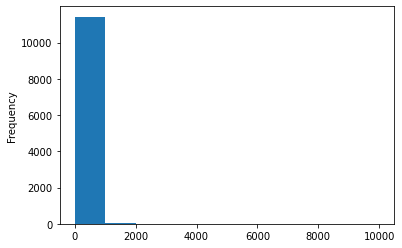

In [11]:
data.price.plot.hist()
#This data needs to be trimmed due to outliers

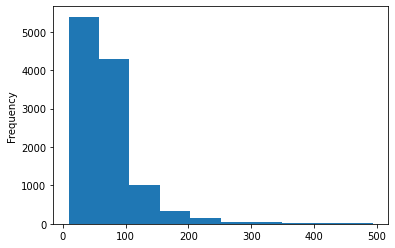

In [12]:
data = data[(data.price <= np.percentile(data["price"], 99)) & (data.price > 0)] # Exclude outliers
data.price.plot.hist()

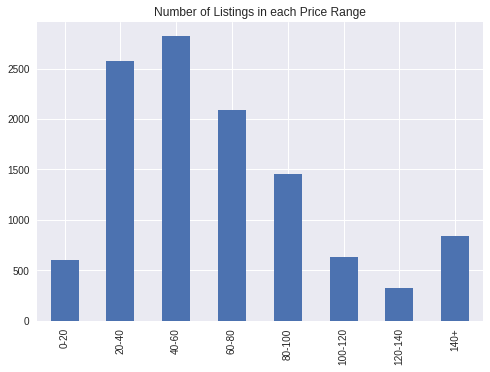

In [13]:
plt.style.use("seaborn")
price_range = pd.cut(data["price"], 
                     bins=[0, 20, 40, 60, 80, 100, 120, 140, data["price"].max()], 
                     labels=["0-20", "20-40", "40-60", "60-80", "80-100", "100-120", "120-140", "140+"])
data["price_range"] = price_range 
data["price_range"].value_counts().sort_index().plot(kind="bar")
plt.title("Number of Listings in each Price Range")
plt.show()

In [14]:
# Adjusting columns in apartments dataframe
data_apartments["price_range"] = np.zeros(28)

In [15]:
selected = []
host = ['host_is_superhost', 'host_neighbourhood', 'host_listings_count', 'host_total_listings_count', 'host_verifications', 'host_identity_verified']
location = ['neighbourhood', 'neighbourhood_cleansed', 'neighbourhood_group_cleansed']
geo = ["latitude", "longitude"]
condition = ['property_type', 'room_type', 'bed_type', 'amenities', 'cleaning_fee', 'minimum_nights']
review = ['review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value']
size = ['space', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'square_feet']
others = ['instant_bookable', 'is_business_travel_ready', 'cancellation_policy']

#Plots about hosts

In [16]:
data.describe(include="all")[host]

host_is_superhost host_neighbourhood  host_listings_count  \
count              11328               7642         11328.000000   
unique                 2                 39                  NaN   
top                    f       Leopoldstadt                  NaN   
freq                8289                928                  NaN   
mean                 NaN                NaN            32.257327   
std                  NaN                NaN           285.914807   
min                  NaN                NaN             0.000000   
25%                  NaN                NaN             1.000000   
50%                  NaN                NaN             2.000000   
75%                  NaN                NaN             7.000000   
max                  NaN                NaN          3750.000000   

        host_total_listings_count  host_verifications host_identity_verified  
count                11328.000000               11332                  11328  
unique                        NaN                 240                      2  
top                           NaN  ['email', 'phone']                      t  
freq                          NaN                1642                   8602  
mean                    32.257327                 NaN                    NaN  
std                    285.914807                 NaN                    NaN  
min                      0.000000                 NaN                    NaN  
25%                      1.000000                 NaN                    NaN  
50%                      2.000000                 NaN                    NaN  
75%                      7.000000                 NaN                    NaN  
max                   3750.000000                 NaN                    NaN

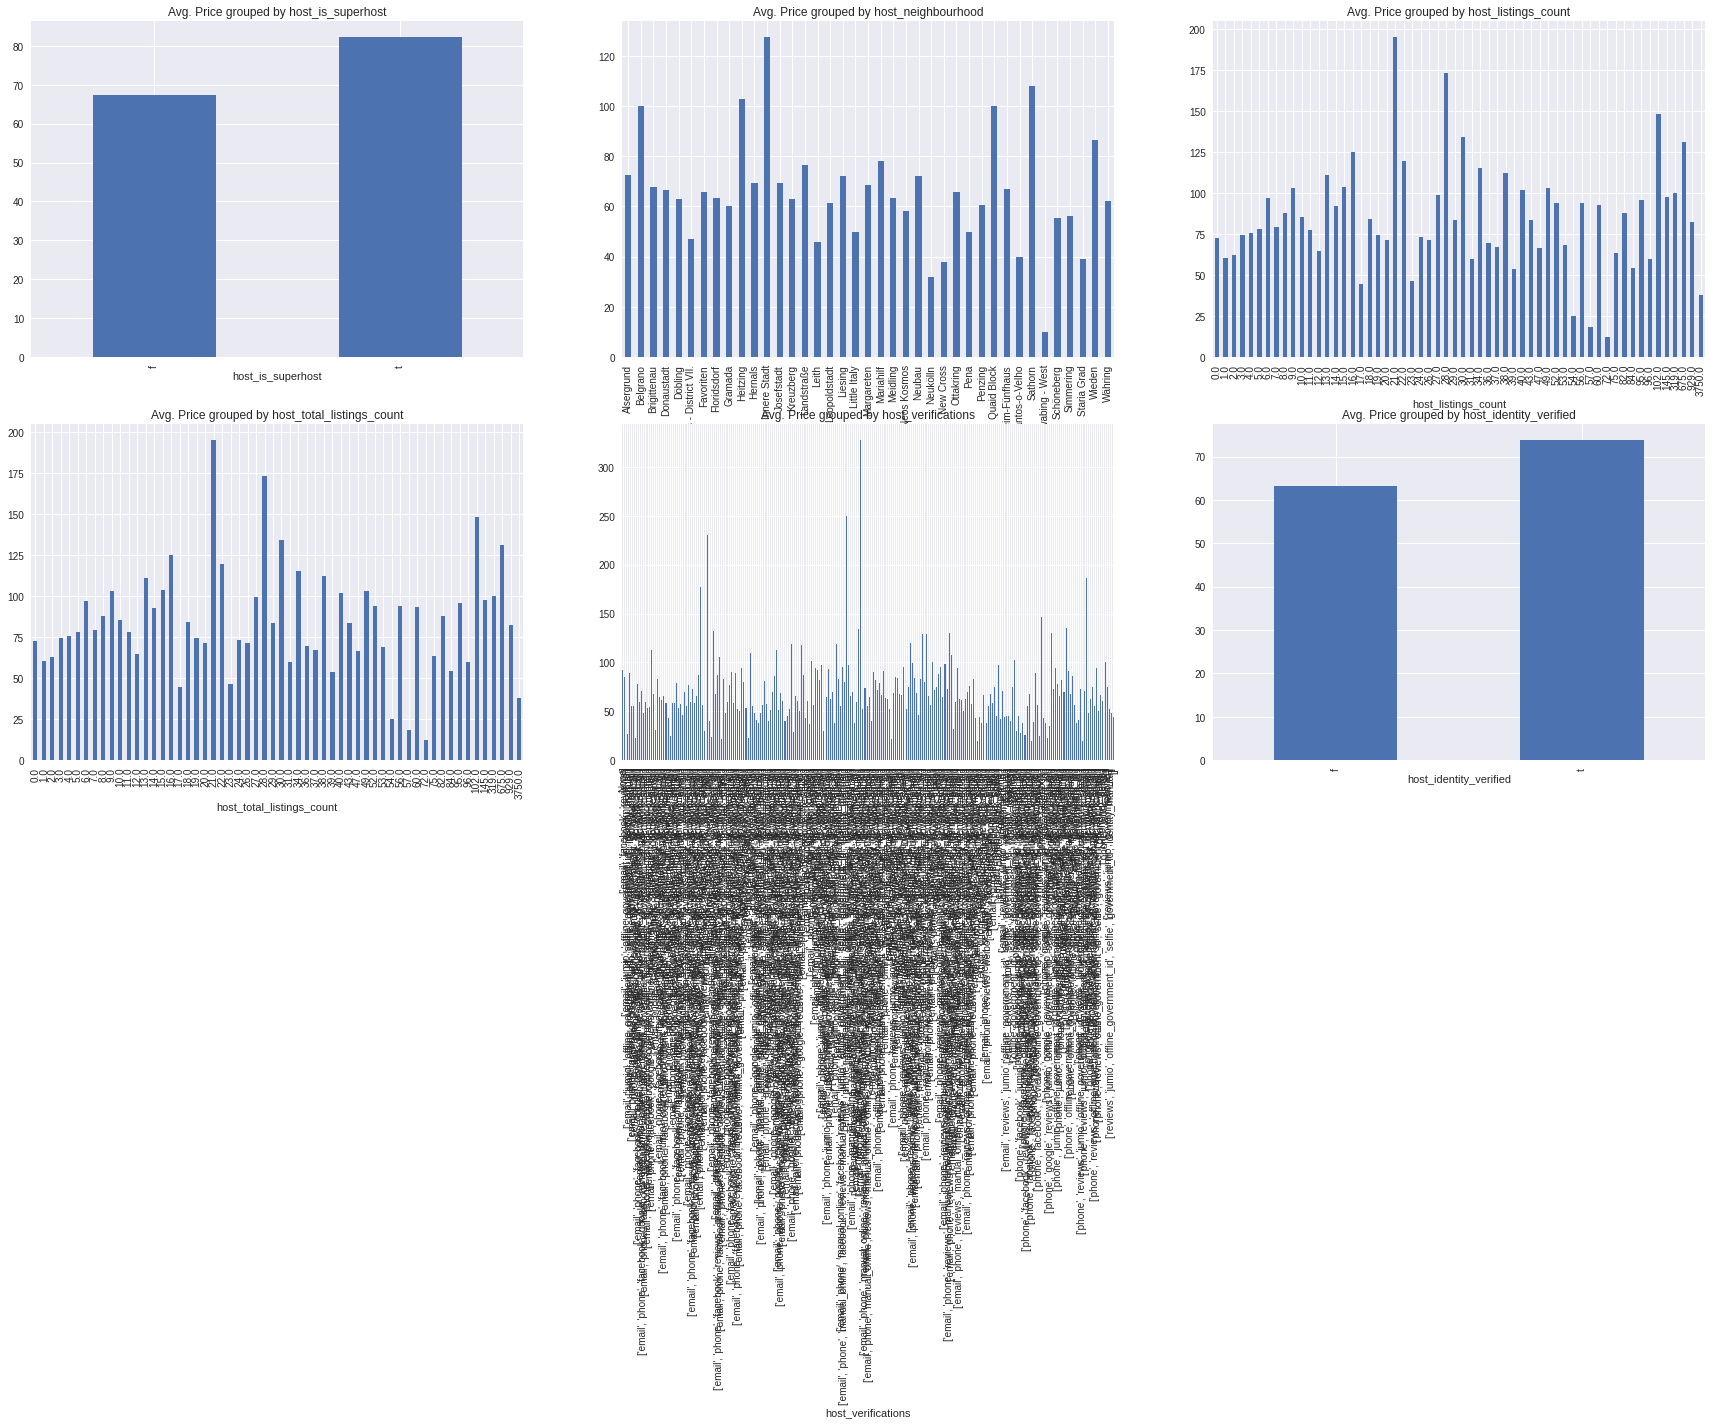

In [17]:
n_cols = 3
n_rows = np.ceil((len(host)+1)/n_cols)
i = 1
for col in host:
  plt.subplot(n_rows, n_cols, i)
  avg_price_host = data.groupby(col).mean()["price"]
  avg_price_host.plot(kind="bar", figsize=(10*n_cols, 7*n_rows))
  plt.title("Avg. Price grouped by "+col)
  i=i+1

plt.show()

In [18]:
index = []
i=0
for col in host:
  if data[col].nunique() >= 10:
    index.append(i)
    i=i+1
  else:
    i=i+1
    continue
host = np.delete(host, index)

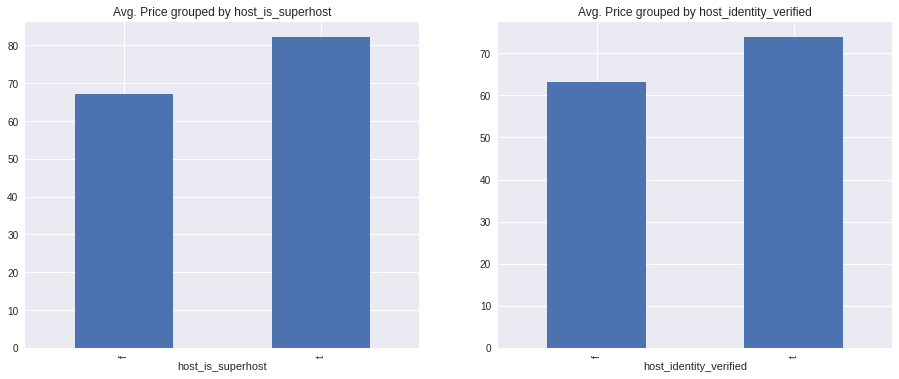

In [19]:
n_cols = 3
n_rows = np.ceil((len(host)+1)/n_cols)
i = 1
for col in host:
  plt.subplot(n_rows, n_cols, i)
  avg_price_host = data.groupby(col).mean()["price"]
  avg_price_host.plot(kind="bar", figsize=(8*n_cols, 6*n_rows))
  plt.title("Avg. Price grouped by "+col)
  i=i+1

plt.show()

#Adjusting host data

In [20]:
data["host_is_superhost"] = data["host_is_superhost"].replace(np.NAN, "f")
data["host_identity_verified"] =data["host_identity_verified"].replace(np.NAN, "f")

In [21]:
#Adjusting Apartments data
data_apartments["host_is_superhost"] = data_apartments["host_is_superhost"].replace(np.NAN, "f")
data_apartments["host_identity_verified"] =data_apartments["host_identity_verified"].replace(np.NAN, "f")

Now we can perform a statistical test: t-test

In [22]:
from scipy import stats
from statsmodels.stats.multicomp import (pairwise_tukeyhsd, MultiComparison)
# Define multicomp function
def multicomp(target_name, group_name, data):
    if (np.nan in data[target_name]) | (np.nan in data[group_name]):
        print("Please remove NaN in target variable or group variable!")
    elif (data[target_name].nunique() == 1) | (data[group_name].nunique() == 1):
        print("There is only one unique value in target variable or group variable.")
    elif data[group_name].nunique() == 2:
        mod = MultiComparison(data[target_name], data[group_name])
        comp = mod.allpairtest(stats.ttest_ind)
        print(comp[0])
    else:
        mod = MultiComparison(data[target_name], data[group_name])
        print(mod.tukeyhsd().summary())
multicomp("price", "host_is_superhost", data)
multicomp("price", "host_identity_verified", data)

Test Multiple Comparison ttest_ind 
FWER=0.05 method=bonf
alphacSidak=0.05, alphacBonf=0.050
group1 group2   stat  pval pval_corr reject
-------------------------------------------
     f      t -13.726  0.0       0.0   True
-------------------------------------------
Test Multiple Comparison ttest_ind 
FWER=0.05 method=bonf
alphacSidak=0.05, alphacBonf=0.050
group1 group2   stat  pval pval_corr reject
-------------------------------------------
     f      t -9.2699  0.0       0.0   True
-------------------------------------------


Both null hypotesis were rejected, so both values shall be used

In [23]:
host_info = ["host_is_superhost", "host_identity_verified"]
for i in host_info:
  selected.append(i)
selected

['host_is_superhost', 'host_identity_verified']

Let's handle host verifications

In [24]:
# Changing ['email', 'phone', 'reviews'] to [email, phone, reviews]
data["host_ver_types"] = data["host_verifications"].apply(lambda x: x[1:-1].replace("\'", "").split(", "))
#data["host_ver_types"]

In [25]:
# Counting number of verification types in the apartment
data["host_ver_type_counts"] = data["host_ver_types"].apply(lambda x: len(x))
#data["host_ver_type_counts"] 

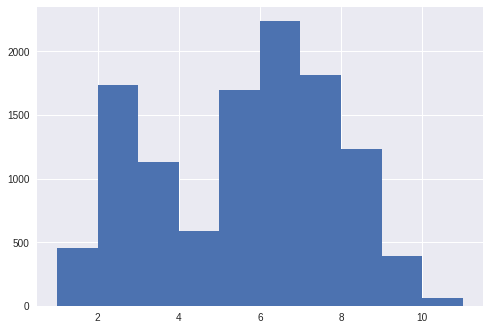

In [26]:
data["host_ver_type_counts"].hist()

In [27]:
# Here we iterate per all verification types and add to new list (with duplicates)
host_ver_types = []
for i in data["host_ver_types"]:
    host_ver_types += i

#host_ver_types

In [28]:
# Here we check count of verifications without replacement and put it in a dictionary
host_ver_types_freq = dict((x, host_ver_types.count(x)) for x in set(host_ver_types))
host_ver_types_freq

{'': 3,
 'weibo': 1,
 'offline_government_id': 5474,
 'photographer': 1,
 'on': 4,
 'reviews': 6504,
 'identity_manual': 3575,
 'zhima_selfie': 5,
 'selfie': 3743,
 'sesame': 1,
 'sent_id': 8,
 'phone': 11298,
 'jumio': 5710,
 'google': 344,
 'sesame_offline': 1,
 'government_id': 7603,
 'manual_online': 60,
 'work_email': 1829,
 'email': 10435,
 'facebook': 1432,
 'kba': 18,
 'manual_offline': 150}

In [29]:
# Creating a DataFreame from dictionary created above
host_ver_types_freq = pd.DataFrame.from_dict(host_ver_types_freq, orient="index")
# Reseting an index and changing column names
host_ver_types_freq.reset_index(inplace=True)
host_ver_types_freq.columns = ["Verification", "Frequency"]
# Picking most frequent verification types in selected order
host_ver_types_freq = host_ver_types_freq.sort_values(by="Frequency", ascending=True)
host_ver_types_freq = host_ver_types_freq[host_ver_types_freq.Frequency >25]
host_ver_types_freq

Verification  Frequency
16          manual_online         60
21         manual_offline        150
13                 google        344
19               facebook       1432
17             work_email       1829
6         identity_manual       3575
8                  selfie       3743
2   offline_government_id       5474
12                  jumio       5710
5                 reviews       6504
15          government_id       7603
18                  email      10435
11                  phone      11298

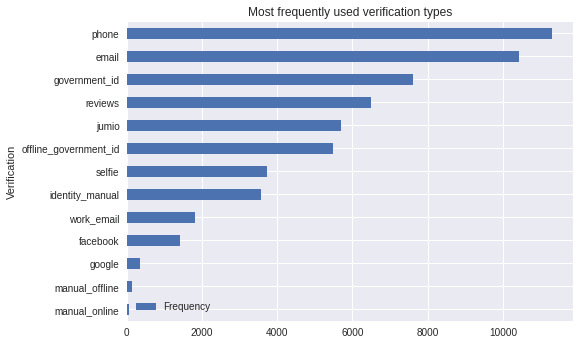

In [30]:
host_ver_types_freq.plot.barh(x="Verification", y="Frequency")
plt.title("Most frequently used verification types")
plt.show()

#Geoplot

In [31]:
import plotly.graph_objects as go
import plotly.express as px
from plotly import tools
from plotly.offline import plot as plotoffline
import seaborn as sns

Creating a dataset

In [32]:
geo = data[['latitude', 'longitude', 'price', 'price_range']]
geo = geo.sort_values("price", ascending=True) # This sorting is necessary for the color scale to work properly. 
geo.describe()

latitude     longitude         price
count  11332.000000  11332.000000  11332.000000
mean      48.205145     16.360884     71.260413
std        0.020461      0.035371     51.572250
min       48.125280     16.193170      9.000000
25%       48.191540     16.338957     39.000000
50%       48.204265     16.358075     60.000000
75%       48.218590     16.381032     88.000000
max       48.320070     16.546620    494.000000

Simple scatter plot

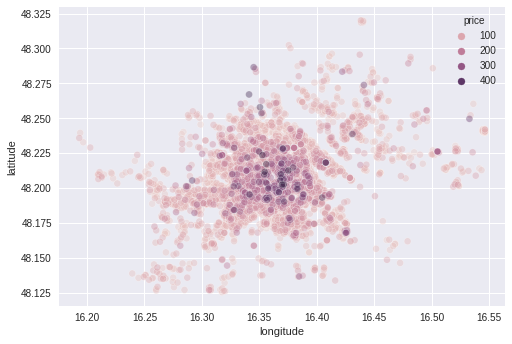

In [33]:
sns.scatterplot(x="longitude", 
                y="latitude", 
                hue="price", 
                data=geo, 
                alpha=0.4)

Below we have created map with marked prices from several ranges

In [34]:
# Map plot
from textwrap import wrap

px.set_mapbox_access_token("pk.eyJ1IjoiZ2F3cm9ubiIsImEiOiJjbDNzeXllNWkxMnl4M2psdHRtZGZkODh0In0.hSntC8Rp50ICzYyvo606nA") # Replace XXX with your Mapbox Token

#Token created here: https://account.mapbox.com/access-tokens 
#I think, that simmilar map could be generated via one of books from python - ćwiczenia
fig = px.scatter_mapbox(geo, 
                        lat="latitude", 
                        lon="longitude", 
                        color="price_range",
                        color_continuous_scale=px.colors.sequential.Aggrnyl,# Na tej stronie można sobie wybierać różne skale kolorów https://plotly.com/python/builtin-colorscales/
                        opacity=0.9, 
                        zoom=10)
fig.show()

In [35]:
data.neighbourhood_cleansed.unique()

array(['Donaustadt', 'Leopoldstadt', 'Rudolfsheim-F\x9fnfhaus',
       'Ottakring', 'Brigittenau', 'Neubau', 'Margareten', 'Hernals',
       'Floridsdorf', 'Alsergrund', 'Simmering', 'Wieden', 'Mariahilf',
       'Josefstadt', 'Penzing', 'Landstra§e', 'Innere Stadt',
       'W\x8ahring', 'Meidling', 'Favoriten', 'D\x9abling', 'Liesing',
       'Hietzing'], dtype=object)

Top 5 places in Vienna are:

Schönbrunn Palace: 48.186370341630735, 16.312763999999905

Hofburg: 48.20612972164898, 16.36478030001803

St. Stephen's Cathedral: 48.208911896028305, 16.37351361576693

Vienna City Hall: 48.21152996635869, 16.35650840000459

Prater: 48.21690060530818, 16.398075622057405

Calcuate the distance bwteen the listing and mianat tractions in Geneva

In [36]:
# Formula to calculate distances
from math import sin, cos, sqrt, atan2, radians
def distance(lat1, lat2, lon1, lon2):
    R = 6373.0
    rlat1 = radians(lat1)
    rlat2 = radians(lat2)
    rlon1 = radians(lon1)
    rlon2 = radians(lon2)
    rdlon = rlon2 - rlon1
    rdlat = rlat2 - rlat1
    a = sin(rdlat / 2)**2 + cos(rlat1) * cos(rlat2) * sin(rdlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    distance = R * c
    return distance

In [37]:
# Top locations in Vienna
toploc = {"Palace": [48.186370341630735, 16.312763999999905], 
          "Hofburg": [48.20612972164898, 16.36478030001803], 
          "Cathedral": [48.208911896028305, 16.37351361576693], 
          "Hall": [48.21152996635869, 16.35650840000459], 
          "Prater": [48.21690060530818, 16.398075622057405]}

In [38]:
toploc = pd.DataFrame.from_dict(toploc)
toploc_trans = toploc.transpose()
toploc_trans.columns = ["latitude", "longitude"]

In [39]:
# Draw a plot with top locations

fig = px.scatter_mapbox(toploc_trans, 
                        lat="latitude", 
                        lon="longitude", 
                        zoom=10)
fig.show()

In [40]:
# Construct distance columns
dist = []
for col in toploc.columns:
    data["dist_"+col] = data.apply(lambda x: distance(x.latitude, toploc[col][0], x.longitude, toploc[col][1]), axis=1)
    dist.append("dist_"+col)

# In "dist" list there are names of all hot locations
# Here we are counting the distance between an apartment nand selected hot location. So we have 5 new numerical columns.

In [41]:
dist_apartments = []
for col in toploc.columns:
    data_apartments["dist_"+col] = data_apartments.apply(lambda x: distance(x.latitude, toploc[col][0], x.longitude, toploc[col][1]), axis=1)
    dist_apartments.append("dist_"+col)

Below 5 last columns

In [42]:
data.iloc[:5, -5:]

dist_Palace  dist_Hofburg  dist_Cathedral  dist_Hall  dist_Prater
0    10.567719      6.180005        5.492004   6.305820     3.604490
1     6.081021      1.769789        1.202541   1.829322     1.487804
2     1.080344      3.703631        4.399793   3.732263     6.393367
3     5.994482      1.645860        1.052585   1.769970     1.456324
4     6.086503      1.711915        1.085368   1.879901     1.328584

The correlation between price and dist_Palace is  0.0433 with a p-value of  0.0000.
The correlation between price and dist_Hofburg is -0.1233 with a p-value of  0.0000.
The correlation between price and dist_Cathedral is -0.1417 with a p-value of  0.0000.
The correlation between price and dist_Hall is -0.0887 with a p-value of  0.0000.
The correlation between price and dist_Prater is -0.1126 with a p-value of  0.0000.


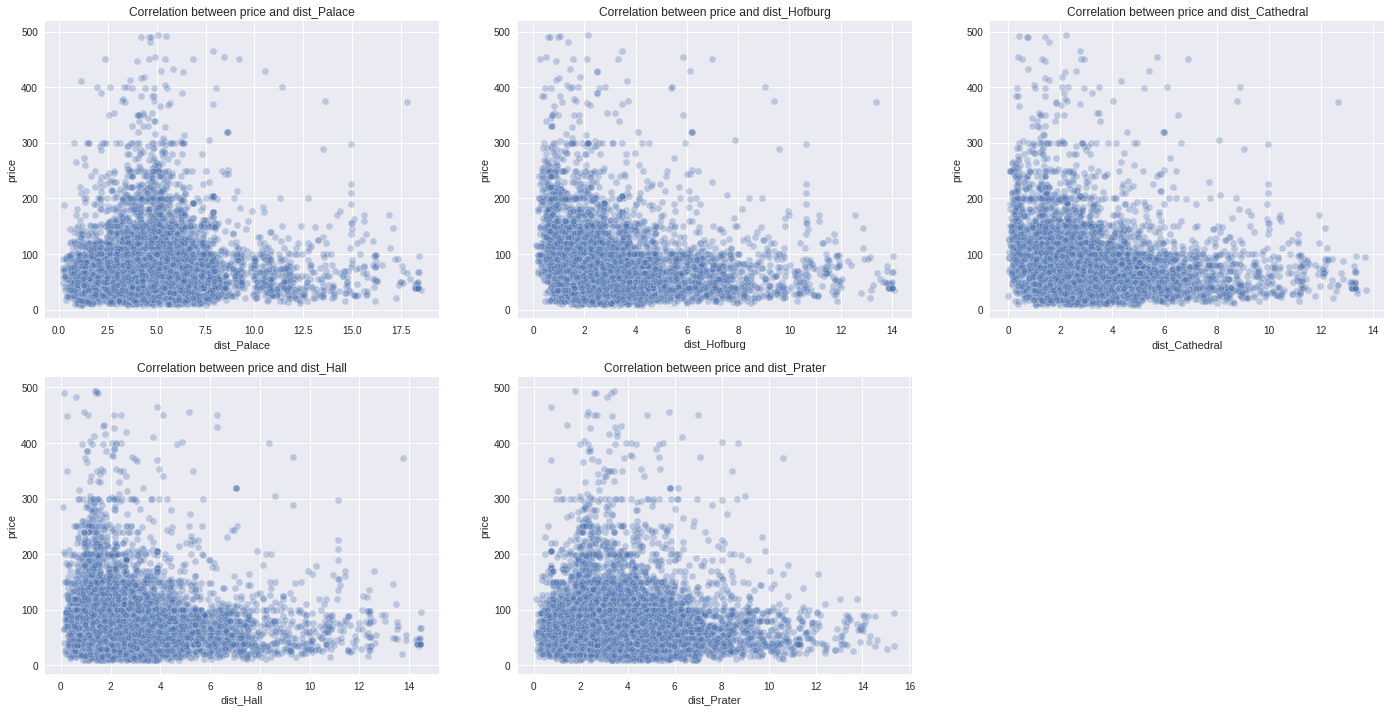

In [43]:
# Here we count and plot Pearson correlation between distance to selected top location and a price
n_cols = 3
n_rows = np.ceil((len(dist)+1)/n_cols)
i = 1
plt.figure(figsize=(8*n_cols, 6*n_rows))
for distance in dist:
  plt.subplot(n_rows, n_cols, i)
  sns.scatterplot(x=distance, y="price", data=data, alpha=0.3)
  plt.title("Correlation between price and "+distance)
  i=i+1
  print("The correlation between price and "+distance+ " is {0[0]: .4f} with a p-value of {0[1]: .4f}.".format(stats.pearsonr(data[-data[distance].isna()][distance], data[-data[distance].isna()]["price"])))

plt.show()

Corellation is high everywhere and p value is always 0

In [44]:
# Next step is to categorize distance columns to True, False (Close, Not close)
for distance in dist:
   data[distance+"_close"] = (data[distance] < 0.8 * (data[distance].median()))
   print(data.groupby(distance+"_close").mean()["price"])

# Finaly we can add one last column with the verdict - can we mark an appartment as well located
toploc_column_names = ['dist_{0}_close'.format(i) for i in toploc.columns]
data["good_distance"] = data.apply(lambda x: any(x[col] for col in toploc_column_names), axis=1)

dist_Palace_close
False    75.434854
True     63.771943
Name: price, dtype: float64
dist_Hofburg_close
False    64.155824
True     86.328560
Name: price, dtype: float64
dist_Cathedral_close
False    63.950839
True     86.688169
Name: price, dtype: float64
dist_Hall_close
False    65.949872
True     81.258713
Name: price, dtype: float64
dist_Prater_close
False    65.405269
True     82.792715
Name: price, dtype: float64


In [45]:
# Repeating operation for selected apartmens
for distance in dist_apartments:
   data_apartments[distance+"_close"] = (data_apartments[distance] < data_apartments[distance].median())
   print(data_apartments.groupby(distance+"_close").mean()["price"])

data_apartments["good_distance"] = data_apartments.apply(lambda x: any([x.dist_Palace_close, x.dist_Hofburg_close, x.dist_Cathedral_close, x.dist_Hall_close, x.dist_Prater_close]), axis=1)

dist_Palace_close
False     NaN
True     95.0
Name: price, dtype: float64
dist_Hofburg_close
False    95.0
True      NaN
Name: price, dtype: float64
dist_Cathedral_close
False    95.0
True      NaN
Name: price, dtype: float64
dist_Hall_close
False    95.0
True      NaN
Name: price, dtype: float64
dist_Prater_close
False    95.0
True      NaN
Name: price, dtype: float64


We can see histogram below, which informs us, that mean price of locations with small distance to top 5 attractions in the city is higher.

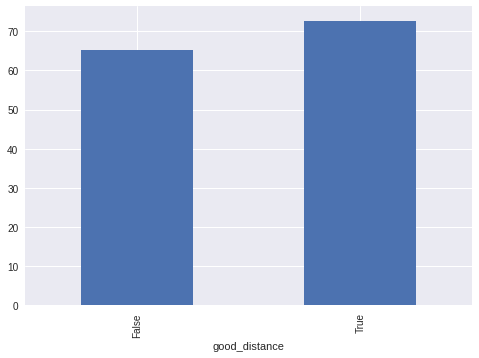

In [46]:
data.groupby("good_distance").mean()["price"].plot(kind="bar")
plt.show()

In [47]:
data.iloc[:5, -6:]

dist_Palace_close  dist_Hofburg_close  dist_Cathedral_close  \
0              False               False                 False   
1              False                True                  True   
2               True               False                 False   
3              False                True                  True   
4              False                True                  True   

   dist_Hall_close  dist_Prater_close  good_distance  
0            False              False          False  
1             True               True           True  
2            False              False           True  
3             True               True           True  
4             True               True           True

We can append then this criterion to our selected table:

In [48]:
selected.append("good_distance")
selected

['host_is_superhost', 'host_identity_verified', 'good_distance']

#Neighbourhood statistics

We would also like to check the popularity and price level at each neighbourhood of Geneva.

In [49]:
# Top popular nerghbourhoods
neighbourhood_group_pop = pd.DataFrame(data["neighbourhood_cleansed"].value_counts())
neighbourhood_group_pop.head(5)

neighbourhood_cleansed
Leopoldstadt                            1221
Landstra§e                              1039
Rudolfsheim-Fnfhaus                     850
Favoriten                                690
Neubau                                   680

In [50]:
# Average price of each neighbourhood
neighbourhood_group_price = data.groupby("neighbourhood_cleansed").mean()["price"]
neighbourhood_group_price = pd.DataFrame(neighbourhood_group_price)
neighbourhood_group_price.sort_values("price", ascending=False).head(5)

price
neighbourhood_cleansed            
Innere Stadt            134.353251
Wieden                   84.586957
Landstra§e               77.149182
Mariahilf                75.769643
Neubau                   74.380882

In [51]:
# Create neighbourhood stats
neighbourhood_stat = pd.merge(neighbourhood_group_pop, 
                              neighbourhood_group_price, 
                              how="inner", left_index=True, right_index=True)
neighbourhood_stat.reset_index(inplace=True)
neighbourhood_stat.columns = ["neighbourhood_cleansed", "count_properties", "avg_price"]
neighbourhood_stat = neighbourhood_stat.sort_values(by="count_properties", ascending=False)
neighbourhood_stat.head(10)

neighbourhood_cleansed  count_properties   avg_price
0           Leopoldstadt              1221   66.846847
1             Landstra§e              1039   77.149182
2   Rudolfsheim-Fnfhaus               850   62.207059
3              Favoriten               690   63.111594
4                 Neubau               680   74.380882
5             Alsergrund               665   68.723308
6             Margareten               644   62.378882
7           Innere Stadt               569  134.353251
8              Ottakring               560   57.246429
9              Mariahilf               560   75.769643

In [52]:
#Addition of filter, which consists of neighbourhoods with at least XXXX properties
neighbourhood_stat_limited = neighbourhood_stat[neighbourhood_stat['count_properties']>40]

Below getting rid of Latvian letters - important note, that letters were changed only in set_limited to above 40 locals in one neighbourhood!!

In [53]:
!pip install unidecode
import unidecode
neighbourhood_stat_limited['neighbourhood_cleansed'] = neighbourhood_stat_limited['neighbourhood_cleansed'].apply(lambda x: unidecode.unidecode(x))
neighbourhood_stat_limited

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.9/235.9 KB 4.7 MB/s eta 0:00:00


neighbourhood_cleansed  count_properties   avg_price
0            Leopoldstadt              1221   66.846847
1             LandstraSSe              1039   77.149182
2     Rudolfsheim-Fnfhaus               850   62.207059
3               Favoriten               690   63.111594
4                  Neubau               680   74.380882
5              Alsergrund               665   68.723308
6              Margareten               644   62.378882
7            Innere Stadt               569  134.353251
8               Ottakring               560   57.246429
9               Mariahilf               560   75.769643
10               Meidling               470   60.223404
11                 Wieden               460   84.586957
12            Brigittenau               438   65.995434
13             Josefstadt               423   72.167849
14             Donaustadt               343   69.653061
15                 Whring               330   64.339394
16                Hernals               314   61.805732
17                Penzing               313   60.431310
18                 Dbling               235   73.072340
19              Simmering               171   63.789474
20               Hietzing               138   64.811594
21            Floridsdorf               136   67.191176
22                Liesing                83   68.421687

<Figure size 576x396 with 0 Axes>

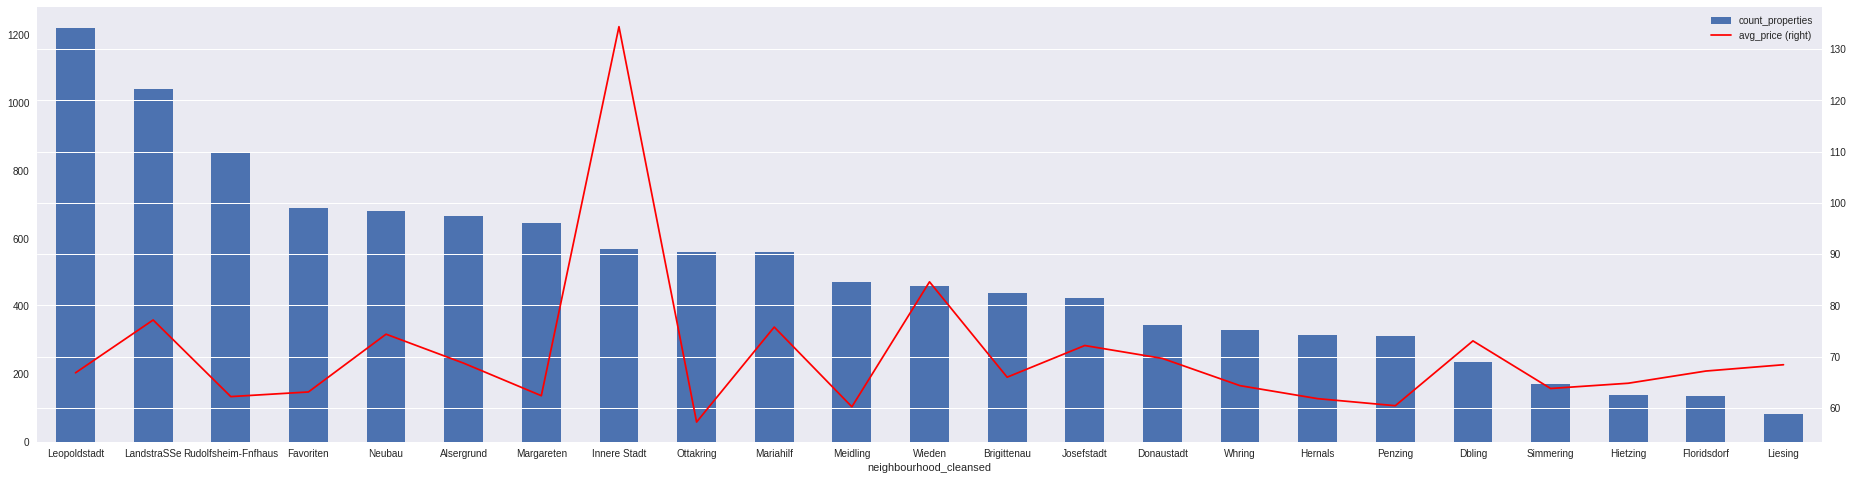

In [54]:
#Drawing a plot with relation - No. of properties vs avg price in selected neighbourhood
fig = plt.figure()

ax = neighbourhood_stat_limited.plot(x="neighbourhood_cleansed", y="count_properties", kind="bar", figsize=(32, 8))
neighbourhood_stat_limited.plot(x="neighbourhood_cleansed", y="avg_price", secondary_y=True, color="red", ax=ax)

plt.show()

#Condition statistics

We would also like to check the impact of conditions.

In [55]:
condition = ['property_type', 'room_type', 'amenities', 'minimum_nights', 'maximum_nights']

In [56]:
data[condition].head()

property_type        room_type  \
0    Room in bed and breakfast       Hotel room   
1           Entire rental unit  Entire home/apt   
2           Entire rental unit  Entire home/apt   
3           Entire rental unit  Entire home/apt   
4  Private room in rental unit     Private room   

                                           amenities  minimum_nights  \
0  ["Pack \u2019n play/Travel crib", "Bed linens"...               1   
1  ["Coffee maker", "Dining table", "Portable fan...              28   
2  ["Body soap", "Coffee maker", "Shower gel", "D...               1   
3  ["Coffee maker", "Shampoo", "Hot water", "Smok...              28   
4  ["Coffee maker", "Dishwasher", "Shampoo", "Ind...               2   

   maximum_nights  
0             365  
1             100  
2             180  
3             100  
4            1000

property type

In [57]:
# Table with selected property type and average price per property type
prop_type_avg_price = data.groupby("property_type").mean()["price"]
prop_type_count_listings = data["property_type"].value_counts()
prop_type_stat = pd.merge(prop_type_count_listings, prop_type_avg_price, how="inner", left_index=True, right_index=True)
prop_type_stat.columns = ["count_prop", "avg_price"]
prop_type_stat.sort_values(by="count_prop", ascending=False).head(10)

count_prop   avg_price
Entire rental unit                         7080   78.446045
Private room in rental unit                2189   35.446323
Entire condominium (condo)                  575   79.820870
Entire serviced apartment                   359  116.256267
Entire loft                                 157   87.101911
Private room in condominium (condo)         101   48.099010
Entire condo                                 84   72.380952
Room in boutique hotel                       70  130.100000
Entire residential home                      70  113.814286
Private room in hostel                       65   65.476923

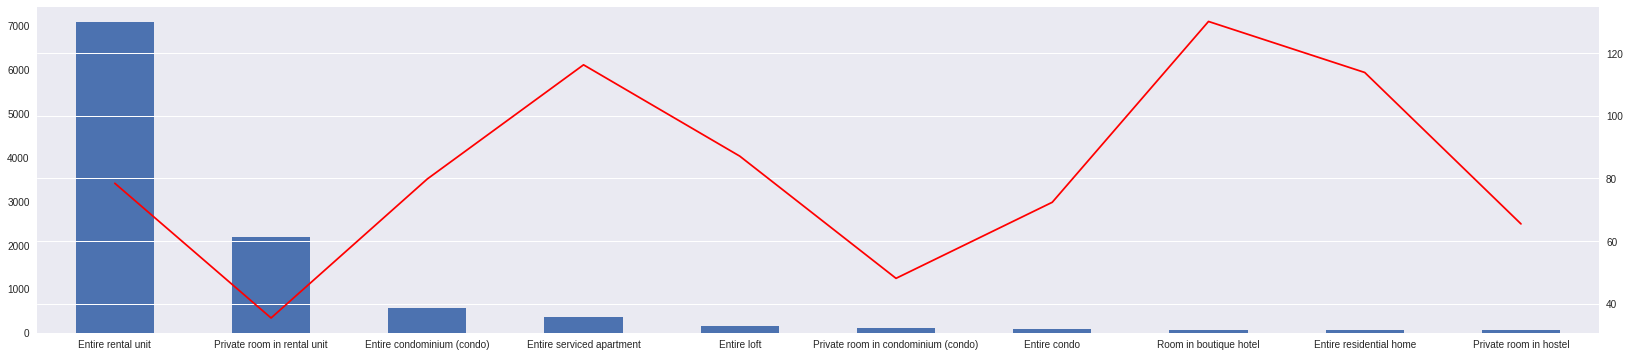

In [58]:
# Drawing a plot with relation - No. of properties vs avg price in selected property type
prop_type_stat_limited = prop_type_stat[prop_type_stat['count_prop']>60] #Trzeba było ograniczyć liczbe rodzajów lokli
fig = plt.figure()
ax = prop_type_stat_limited['count_prop'].plot(x="neighbourhood_cleansed", y="count_properties", kind="bar", figsize=(28, 6))
prop_type_stat_limited['avg_price'].plot(x="neighbourhood_cleansed", y="avg_price", secondary_y=True, color="red", ax=ax)
plt.show()

Room type

In [59]:
# Table with selected room type and average price per room type
room_type_avg_price = data.groupby("room_type").mean()["price"]
room_type_count_listings = data["room_type"].value_counts()
room_type_stat = pd.merge(room_type_count_listings, room_type_avg_price, how="inner", left_index=True, right_index=True)
room_type_stat.columns = ["count_prop", "avg_price"]
room_type_stat.sort_values(by="count_prop", ascending=False).head(10)

count_prop   avg_price
Entire home/apt        8455   80.756949
Private room           2743   41.822093
Shared room              75   38.186667
Hotel room               59  121.033898

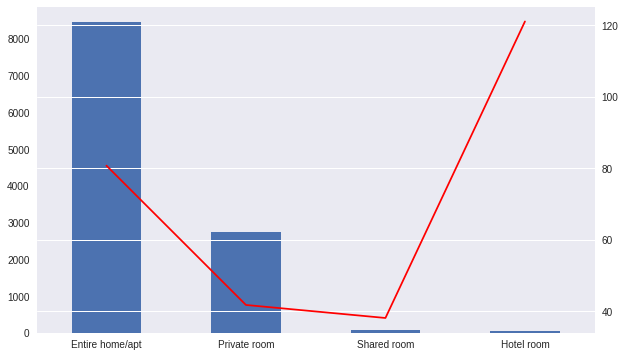

In [60]:
# Drawing a plot with relation - No. of properties vs avg price in selected room type
fig = plt.figure()
ax = room_type_stat['count_prop'].plot(x="neighbourhood_cleansed", y="count_properties", kind="bar", figsize=(10, 6))
room_type_stat['avg_price'].plot(x="neighbourhood_cleansed", y="avg_price", secondary_y=True, color="red", ax=ax)
plt.show()

Entire apartment has a significant higher price than a private room. Therefore we take it into our model.

In [61]:
data["is_entire_apt"] = data["room_type"]=="Entire home/apt"
selected.append("is_entire_apt")

In [62]:
#Adjusting Apartments data
data_apartments["is_entire_apt"] = data_apartments["room_type"]=="Entire home/apt"

Amendities

In [63]:
data["amenities"].head()

0    ["Pack \u2019n play/Travel crib", "Bed linens"...
1    ["Coffee maker", "Dining table", "Portable fan...
2    ["Body soap", "Coffee maker", "Shower gel", "D...
3    ["Coffee maker", "Shampoo", "Hot water", "Smok...
4    ["Coffee maker", "Dishwasher", "Shampoo", "Ind...
Name: amenities, dtype: object

In [64]:
data["amenities"] =data["amenities"].apply(lambda x: x[1:-1].replace("\'", "").replace(' "', '').replace('"', '').replace(" ", "_").split(","))
data["amenities"].head()

0    [Pack_\u2019n_play/Travel_crib, Bed_linens, Lo...
1    [Coffee_maker, Dining_table, Portable_fans, Sh...
2    [Body_soap, Coffee_maker, Shower_gel, Dining_t...
3    [Coffee_maker, Shampoo, Hot_water, Smoke_alarm...
4    [Coffee_maker, Dishwasher, Shampoo, Indoor_fir...
Name: amenities, dtype: object

In [65]:
#Adjusting Apartments data
data_apartments["amenities"] =data_apartments["amenities"].apply(lambda x: x[1:-1].replace("\'", "").replace(' "', '').replace('"', '').replace(" ", "_").split(","))

In [66]:
# Listing all amenities
amenity_types = []
for i in data["amenities"]:
    amenity_types += i
#amenity_types

In [67]:
#Adjusting Apartments data
amenity_types_apartments = []
for i in data_apartments["amenities"]:
    amenity_types_apartments += i

In [68]:
# Table with amenities and their frequency
amenity_types_freq = dict((x, amenity_types.count(x)) for x in set(amenity_types))
amenity_types_freq = pd.DataFrame.from_dict(amenity_types_freq, orient="index")
amenity_types_freq.reset_index(inplace=True)
amenity_types_freq.columns = ["Amenity", "Frequency"]
amenity_types_freq = amenity_types_freq.sort_values(by="Frequency", ascending=False)
amenity_types_freq.head(40)

Amenity  Frequency
324                        Wifi      10753
793                     Kitchen      10549
309                  Essentials      10344
515     Long_term_stays_allowed       9932
286                     Heating       9849
298                  Hair_dryer       9345
404                     Hangers       8952
44                       Washer       8390
136         Dedicated_workspace       8043
720                        Iron       7990
589                   Hot_water       7540
541       Dishes_and_silverware       6620
297                     Shampoo       6619
505              Cooking_basics       6426
318                Refrigerator       6282
479                Coffee_maker       5717
665                  Bed_linens       5664
626                    Elevator       5348
725                       Stove       5121
674                 Smoke_alarm       4842
681                        Oven       4556
887                  Dishwasher       4472
432                   Microwave       4129
891                          TV       4054
312               First_aid_kit       3444
365           Fire_extinguisher       3401
83             Private_entrance       3182
138       Carbon_monoxide_alarm       2717
860  Extra_pillows_and_blankets       2668
157                    Cable_TV       2657
195                     Lockbox       2592
166                       Dryer       2501
383      TV_with_standard_cable       2498
834       Room-darkening_shades       2387
481   Paid_parking_off_premises       2365
441     Luggage_dropoff_allowed       2365
940             Host_greets_you       2241
112                  Shower_gel       2206
794            Hot_water_kettle       2084
876                Dining_table       2014

In [69]:
# Adjusting Apartments data
amenity_types_freq_apartments = dict((x, amenity_types_apartments.count(x)) for x in set(amenity_types_apartments))
amenity_types_freq_apartments = pd.DataFrame.from_dict(amenity_types_freq_apartments, orient="index")
amenity_types_freq_apartments.reset_index(inplace=True)
amenity_types_freq_apartments.columns = ["Amenity", "Frequency"]
amenity_types_freq_apartments = amenity_types_freq_apartments.sort_values(by="Frequency", ascending=False)

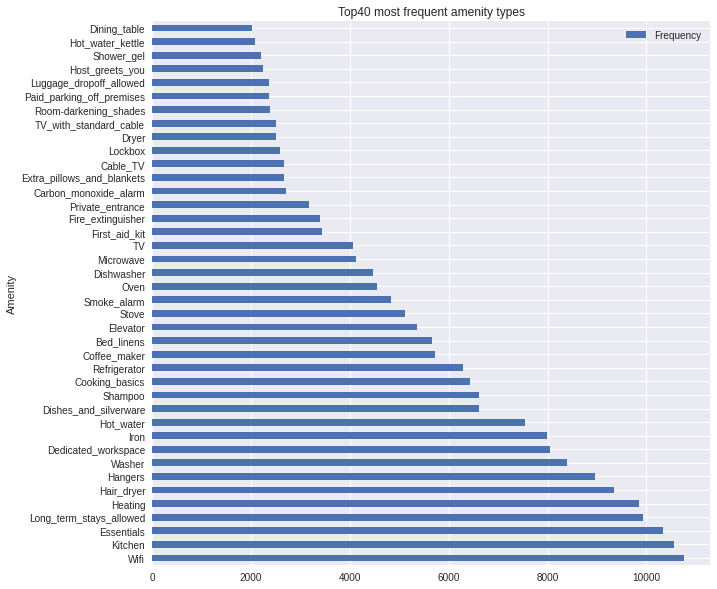

In [70]:
# Plot with top amenities
amenity_types_freq.head(40).plot.barh(x="Amenity", y="Frequency", figsize=(10, 10))
plt.title("Top40 most frequent amenity types")
plt.show()

90%+ listings have the Top3 features: kitchen, Essentials and heatLong term stays allowed. Therefore they won't have a huge impact on price.

It is different, than in other cases - we need to use a for loop, to compleete the same thng, as below

Below selected Amenities, which are in locations between 0.4 and 0.7 of all locales 

In [71]:
amenity_types_freq_selected = amenity_types_freq[amenity_types_freq.Frequency.between(0.4 * data.shape[0], 0.7 * data.shape[0])]
amenity_types_freq_selected

Amenity  Frequency
589              Hot_water       7540
541  Dishes_and_silverware       6620
297                Shampoo       6619
505         Cooking_basics       6426
318           Refrigerator       6282
479           Coffee_maker       5717
665             Bed_linens       5664
626               Elevator       5348
725                  Stove       5121
674            Smoke_alarm       4842
681                   Oven       4556

gettling list of selected Amenities

In [72]:
amenity_list = list(amenity_types_freq_selected.Amenity)
amenity_list

['Hot_water',
 'Dishes_and_silverware',
 'Shampoo',
 'Cooking_basics',
 'Refrigerator',
 'Coffee_maker',
 'Bed_linens',
 'Elevator',
 'Stove',
 'Smoke_alarm',
 'Oven']

Code responsible for aggregation of new dummy columns with chosen amenities

In [73]:
for i in amenity_list:
  data["with_"+i] = data["amenities"].apply(lambda x: i in x)

In [74]:
# Adjusting Apartments data
for i in amenity_list:
  data_apartments["with_"+i] = data_apartments["amenities"].apply(lambda x: i in x)

In [75]:
data.iloc[:10, -(len(amenity_list)):]

with_Hot_water  with_Dishes_and_silverware  with_Shampoo  \
0            True                       False          True   
1            True                        True          True   
2            True                        True          True   
3            True                        True          True   
4            True                        True          True   
5            True                        True          True   
6            True                        True          True   
7            True                        True          True   
8            True                        True          True   
9            True                        True          True   

   with_Cooking_basics  with_Refrigerator  with_Coffee_maker  with_Bed_linens  \
0                False              False              False             True   
1                 True               True               True             True   
2                 True               True               True             True   
3                 True               True               True             True   
4                 True               True               True             True   
5                 True               True               True             True   
6                 True              False              False            False   
7                 True               True               True             True   
8                 True               True               True             True   
9                 True               True               True             True   

   with_Elevator  with_Stove  with_Smoke_alarm  with_Oven  
0          False       False              True      False  
1          False        True              True      False  
2           True       False              True      False  
3          False        True              True      False  
4           True        True             False       True  
5           True        True              True       True  
6          False       False             False      False  
7          False        True              True       True  
8           True        True             False       True  
9          False       False              True       True

In [76]:
# Performing statistical test for selected amenities
for amenit in data.iloc[:, -(len(amenity_list)):].columns:
  print(amenit)
  print(multicomp("price", amenit, data))

with_Hot_water
Test Multiple Comparison ttest_ind 
FWER=0.05 method=bonf
alphacSidak=0.05, alphacBonf=0.050
group1 group2   stat  pval pval_corr reject
-------------------------------------------
 False   True -8.2811  0.0       0.0   True
-------------------------------------------
None
with_Dishes_and_silverware
Test Multiple Comparison ttest_ind 
FWER=0.05 method=bonf
alphacSidak=0.05, alphacBonf=0.050
group1 group2   stat   pval pval_corr reject
--------------------------------------------
 False   True -10.4326  0.0       0.0   True
--------------------------------------------
None
with_Shampoo
Test Multiple Comparison ttest_ind 
FWER=0.05 method=bonf
alphacSidak=0.05, alphacBonf=0.050
group1 group2   stat   pval pval_corr reject
--------------------------------------------
 False   True -14.9709  0.0       0.0   True
--------------------------------------------
None
with_Cooking_basics
Test Multiple Comparison ttest_ind 
FWER=0.05 method=bonf
alphacSidak=0.05, alphacBonf=0.050
gr

We can reject null hypotesis for all selected amenities!

In [77]:
for i in amenity_list:
    selected.append("with_"+i)

In [78]:
selected

['host_is_superhost',
 'host_identity_verified',
 'good_distance',
 'is_entire_apt',
 'with_Hot_water',
 'with_Dishes_and_silverware',
 'with_Shampoo',
 'with_Cooking_basics',
 'with_Refrigerator',
 'with_Coffee_maker',
 'with_Bed_linens',
 'with_Elevator',
 'with_Stove',
 'with_Smoke_alarm',
 'with_Oven']

Minimum nights

In [79]:
data["minimum_nights"].describe()

count    11332.000000
mean         6.799506
std         27.895731
min          1.000000
25%          1.000000
50%          2.000000
75%          3.000000
max       1125.000000
Name: minimum_nights, dtype: float64

In [80]:
for i in range(2, 10):
  data['min_nights_greater_than_{}'.format(i)] = data["minimum_nights"] > i
  multicomp("price", 'min_nights_greater_than_{}'.format(i), data=data)
data.iloc[:10, -8:]

Test Multiple Comparison ttest_ind 
FWER=0.05 method=bonf
alphacSidak=0.05, alphacBonf=0.050
group1 group2  stat   pval  pval_corr reject
--------------------------------------------
 False   True 2.8568 0.0043    0.0043   True
--------------------------------------------
Test Multiple Comparison ttest_ind 
FWER=0.05 method=bonf
alphacSidak=0.05, alphacBonf=0.050
group1 group2  stat  pval pval_corr reject
------------------------------------------
 False   True 8.7165  0.0       0.0   True
------------------------------------------
Test Multiple Comparison ttest_ind 
FWER=0.05 method=bonf
alphacSidak=0.05, alphacBonf=0.050
group1 group2  stat  pval pval_corr reject
------------------------------------------
 False   True 8.5159  0.0       0.0   True
------------------------------------------
Test Multiple Comparison ttest_ind 
FWER=0.05 method=bonf
alphacSidak=0.05, alphacBonf=0.050
group1 group2  stat  pval pval_corr reject
------------------------------------------
 False   True 8.63

min_nights_greater_than_2  min_nights_greater_than_3  \
0                      False                      False   
1                       True                       True   
2                      False                      False   
3                       True                       True   
4                      False                      False   
5                       True                      False   
6                       True                       True   
7                      False                      False   
8                       True                      False   
9                      False                      False   

   min_nights_greater_than_4  min_nights_greater_than_5  \
0                      False                      False   
1                       True                       True   
2                      False                      False   
3                       True                       True   
4                      False                      False   
5                      False                      False   
6                      False                      False   
7                      False                      False   
8                      False                      False   
9                      False                      False   

   min_nights_greater_than_6  min_nights_greater_than_7  \
0                      False                      False   
1                       True                       True   
2                      False                      False   
3                       True                       True   
4                      False                      False   
5                      False                      False   
6                      False                      False   
7                      False                      False   
8                      False                      False   
9                      False                      False   

   min_nights_greater_than_8  min_nights_greater_than_9  
0                      False                      False  
1                       True                       True  
2                      False                      False  
3                       True                       True  
4                      False                      False  
5                      False                      False  
6                      False                      False  
7                      False                      False  
8                      False                      False  
9                      False                      False

In [81]:
#Adjusting apartments data
for i in range(2, 10):
  data_apartments['min_nights_greater_than_{}'.format(i)] = data_apartments["minimum_nights"] > i
  multicomp("price", 'min_nights_greater_than_{}'.format(i), data=data_apartments)

There is only one unique value in target variable or group variable.
There is only one unique value in target variable or group variable.
There is only one unique value in target variable or group variable.
There is only one unique value in target variable or group variable.
There is only one unique value in target variable or group variable.
There is only one unique value in target variable or group variable.
There is only one unique value in target variable or group variable.
There is only one unique value in target variable or group variable.


We can saee, that p is becomming more relevant at min nights = 3, so we may add this factor

In [82]:
selected.append('min_nights_greater_than_3')
selected

['host_is_superhost',
 'host_identity_verified',
 'good_distance',
 'is_entire_apt',
 'with_Hot_water',
 'with_Dishes_and_silverware',
 'with_Shampoo',
 'with_Cooking_basics',
 'with_Refrigerator',
 'with_Coffee_maker',
 'with_Bed_linens',
 'with_Elevator',
 'with_Stove',
 'with_Smoke_alarm',
 'with_Oven',
 'min_nights_greater_than_3']

Lets see about maximum nights

In [ ]:
data["maximum_nights"].describe()

count    11332.000000
mean       608.472556
std       1058.920737
min          1.000000
25%         80.000000
50%        365.000000
75%       1125.000000
max      99999.000000
Name: maximum_nights, dtype: float64

it is hard to estimate something here, so lets ged rid of this max nights criterion

#Review statistics

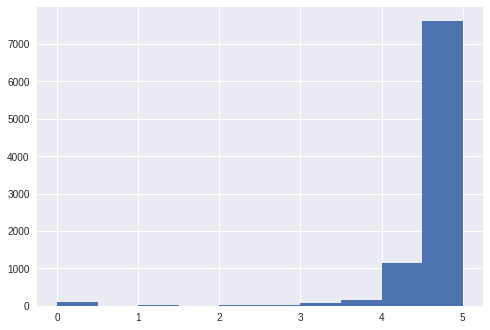

In [ ]:
data["review_scores_rating"].hist()

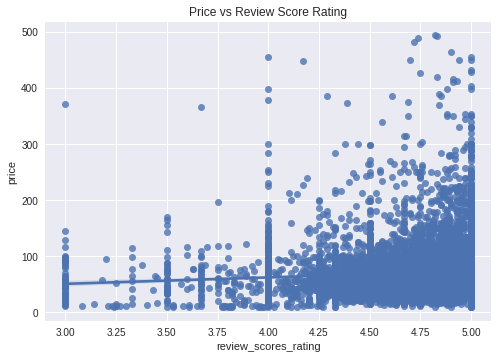

The correlation between review score and price is  0.0575 with a p-value of  0.0000.


In [ ]:
# Scatter plot between review score and price
import seaborn as sns
import scipy.stats as stats
sns.regplot(x="review_scores_rating", y="price", data=data[data["review_scores_rating"]>=3])
plt.title("Price vs Review Score Rating")
plt.show()
print("The correlation between review score and price is {0[0]: .4f} with a p-value of {0[1]: .4f}.".format(stats.pearsonr(data[-data["review_scores_rating"].isna()]["review_scores_rating"], data[-data["review_scores_rating"].isna()]["price"])))

Check the correlation between price and other scores

In [ ]:
for col in review:
    print(("The pearson correlation coefficient between " + col + " and price is {0[0]: .4f} with a p-value of {0[1]: .4f}.").format(stats.pearsonr(data[-data[col].isna()][col],data[-data[col].isna()]["price"])))

The pearson correlation coefficient between review_scores_rating and price is  0.0575 with a p-value of  0.0000.
The pearson correlation coefficient between review_scores_accuracy and price is  0.0286 with a p-value of  0.0065.
The pearson correlation coefficient between review_scores_cleanliness and price is  0.1099 with a p-value of  0.0000.
The pearson correlation coefficient between review_scores_checkin and price is  0.0143 with a p-value of  0.1737.
The pearson correlation coefficient between review_scores_communication and price is  0.0052 with a p-value of  0.6239.
The pearson correlation coefficient between review_scores_location and price is  0.0972 with a p-value of  0.0000.
The pearson correlation coefficient between review_scores_value and price is -0.0201 with a p-value of  0.0555.


Here we can see, that corelation is significant for:

review_scores_rating

review_scores_accurac

review_scores_cleanliness

review_scores_location

Lets write an universal code, to choose proper review attributes

In [ ]:
selected_reviews = []
for col in review:
  if stats.pearsonr(data[-data[col].isna()][col],data[-data[col].isna()]["price"])[1] < 0.05: # Choosing attributes with p-value below 0.05
    selected_reviews.append(col)

selected_reviews

['review_scores_rating',
 'review_scores_accuracy',
 'review_scores_cleanliness',
 'review_scores_location']

In [ ]:
for i in selected_reviews:
    selected.append(i)

selected

['host_is_superhost',
 'host_identity_verified',
 'good_distance',
 'is_entire_apt',
 'with_Hot_water',
 'with_Dishes_and_silverware',
 'with_Shampoo',
 'with_Cooking_basics',
 'with_Refrigerator',
 'with_Coffee_maker',
 'with_Bed_linens',
 'with_Elevator',
 'with_Stove',
 'with_Smoke_alarm',
 'with_Oven',
 'min_nights_greater_than_3',
 'review_scores_rating',
 'review_scores_accuracy',
 'review_scores_cleanliness',
 'review_scores_location']

#Size of apartment

Look at size-related variables

In [ ]:
#Need to adjust data to Vienna provided columns
size = ['accommodates', 'bathrooms', 'bedrooms', 'beds']
data[size].head(10)

accommodates  bathrooms  bedrooms  beds
0             3        NaN       1.0   2.0
1             5        NaN       1.0   3.0
2             6        NaN       2.0   4.0
3             3        NaN       NaN   2.0
4             2        NaN       1.0   2.0
5             4        NaN       2.0   2.0
6             4        NaN       2.0   2.0
7             4        NaN       1.0   2.0
8             2        NaN       1.0   1.0
9             5        NaN       NaN   4.0

In [ ]:
data['bathrooms'].describe()

count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: bathrooms, dtype: float64

it occour, that there are no valuable info in bathrooms column

In [ ]:
data['bathrooms_text'].unique()

array(['1 private bath', '1 bath', '2 shared baths', 'Shared half-bath',
       '1 shared bath', '2 baths', 'Half-bath', '1.5 baths', '3 baths',
       '4.5 baths', '0 baths', '1.5 shared baths', 'Private half-bath',
       nan, '2.5 baths', '3.5 shared baths', '4 baths', '11 baths',
       '3.5 baths', '3 shared baths', '6 baths', '2.5 shared baths',
       '4 shared baths', '8 baths', '5 baths', '0 shared baths',
       '18 shared baths'], dtype=object)

But we count find something interesting in 'bathrooms_text column'

In [ ]:
data['bathrooms'] = np.where(data['bathrooms_text'].str.contains('half',case=False, na=False), 0.5, 
                          data['bathrooms_text'].str.split().str[0]).astype(np.float64)
data[size].head(10)

accommodates  bathrooms  bedrooms  beds
0             3        1.0       1.0   2.0
1             5        1.0       1.0   3.0
2             6        1.0       2.0   4.0
3             3        1.0       NaN   2.0
4             2        2.0       1.0   2.0
5             4        1.0       2.0   2.0
6             4        1.0       2.0   2.0
7             4        1.0       1.0   2.0
8             2        0.5       1.0   1.0
9             5        1.0       NaN   4.0

Check the correlation between number of accommodates and price

In [ ]:
data["accommodates"].describe()

count    11332.000000
mean         3.259884
std          1.781499
min          1.000000
25%          2.000000
50%          3.000000
75%          4.000000
max         16.000000
Name: accommodates, dtype: float64

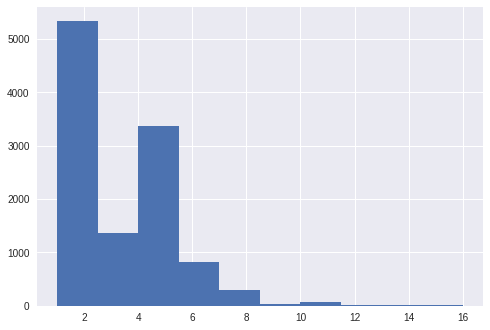

In [ ]:
data["accommodates"].hist()

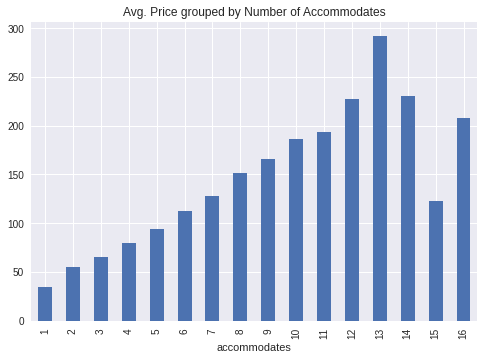

The pearson correlation coefficient between ther number of acoommodates and price is  0.5068 with a p-value of  0.0000.


In [ ]:
data.groupby("accommodates").mean()["price"].plot(kind="bar")
plt.title("Avg. Price grouped by Number of Accommodates")
plt.show()
print("The pearson correlation coefficient between ther number of acoommodates and price is {0[0]: .4f} with a p-value of {0[1]: .4f}.".format(stats.pearsonr(data["accommodates"], data["price"])))

Accommodates can be used as a proxy of space and has sig. correlation with price.

In [ ]:
selected.append("accommodates")
selected

['host_is_superhost',
 'host_identity_verified',
 'good_distance',
 'is_entire_apt',
 'with_Hot_water',
 'with_Dishes_and_silverware',
 'with_Shampoo',
 'with_Cooking_basics',
 'with_Refrigerator',
 'with_Coffee_maker',
 'with_Bed_linens',
 'with_Elevator',
 'with_Stove',
 'with_Smoke_alarm',
 'with_Oven',
 'min_nights_greater_than_3',
 'review_scores_rating',
 'review_scores_accuracy',
 'review_scores_cleanliness',
 'review_scores_location',
 'accommodates']

Check the correlation bewteen accommodates and other size variables

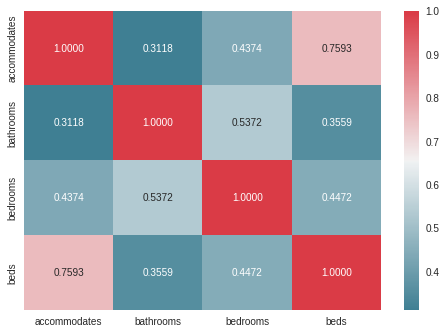

In [ ]:
size_variables = data[size]
size_corr = size_variables.corr()
colormap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(size_corr, cmap=colormap, annot=True, fmt=".4f")

Conclusion: the variable "accommodates" is highly correlated with "beds" and "bedrooms", so it is sufficient to include only accommodates into our model.

nevertheless, due to bedrooms is more important factor, when we are concluding buying apartment - i will add this factor too.

In [ ]:
selected.append("bedrooms")
selected

['host_is_superhost',
 'host_identity_verified',
 'good_distance',
 'is_entire_apt',
 'with_Hot_water',
 'with_Dishes_and_silverware',
 'with_Shampoo',
 'with_Cooking_basics',
 'with_Refrigerator',
 'with_Coffee_maker',
 'with_Bed_linens',
 'with_Elevator',
 'with_Stove',
 'with_Smoke_alarm',
 'with_Oven',
 'min_nights_greater_than_3',
 'review_scores_rating',
 'review_scores_accuracy',
 'review_scores_cleanliness',
 'review_scores_location',
 'accommodates',
 'bedrooms']

After all, I have decided to add bathrooms as well

In [ ]:
selected.append("bathrooms")

#Other conditions

In [ ]:
# I had to limit it due to Vienna data
others = ['instant_bookable']
data[others].head()

instant_bookable
0                f
1                t
2                f
3                t
4                f

Test Multiple Comparison ttest_ind 
FWER=0.05 method=bonf
alphacSidak=0.05, alphacBonf=0.050
group1 group2   stat   pval pval_corr reject
--------------------------------------------
     f      t -12.3566  0.0       0.0   True
--------------------------------------------


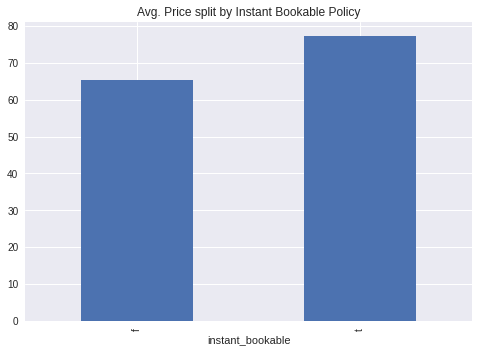

In [ ]:
data["instant_bookable"].value_counts()
multicomp("price", "instant_bookable", data)
data.groupby("instant_bookable").mean()["price"].plot(kind="bar")
plt.title("Avg. Price split by Instant Bookable Policy")
plt.show()

We can add instant bookable then

In [ ]:
selected.append("instant_bookable")
selected

['host_is_superhost',
 'host_identity_verified',
 'good_distance',
 'is_entire_apt',
 'with_Hot_water',
 'with_Dishes_and_silverware',
 'with_Shampoo',
 'with_Cooking_basics',
 'with_Refrigerator',
 'with_Coffee_maker',
 'with_Bed_linens',
 'with_Elevator',
 'with_Stove',
 'with_Smoke_alarm',
 'with_Oven',
 'min_nights_greater_than_3',
 'review_scores_rating',
 'review_scores_accuracy',
 'review_scores_cleanliness',
 'review_scores_location',
 'accommodates',
 'bedrooms',
 'bathrooms',
 'instant_bookable']

We have all selected values!!!

#Feature engineering

In [ ]:
data[selected].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11332 entries, 0 to 11451
Data columns (total 24 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   host_is_superhost           11332 non-null  object 
 1   host_identity_verified      11332 non-null  object 
 2   good_distance               11332 non-null  bool   
 3   is_entire_apt               11332 non-null  bool   
 4   with_Hot_water              11332 non-null  bool   
 5   with_Dishes_and_silverware  11332 non-null  bool   
 6   with_Shampoo                11332 non-null  bool   
 7   with_Cooking_basics         11332 non-null  bool   
 8   with_Refrigerator           11332 non-null  bool   
 9   with_Coffee_maker           11332 non-null  bool   
 10  with_Bed_linens             11332 non-null  bool   
 11  with_Elevator               11332 non-null  bool   
 12  with_Stove                  11332 non-null  bool   
 13  with_Smoke_alarm            113

Convert string variables into categorical variables

In [ ]:
for sel in selected:
  if data[sel].dtype == 'O': # Changing object data type to boolean
    data[sel] = data[sel]=="t"

data[selected].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11332 entries, 0 to 11451
Data columns (total 24 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   host_is_superhost           11332 non-null  bool   
 1   host_identity_verified      11332 non-null  bool   
 2   good_distance               11332 non-null  bool   
 3   is_entire_apt               11332 non-null  bool   
 4   with_Hot_water              11332 non-null  bool   
 5   with_Dishes_and_silverware  11332 non-null  bool   
 6   with_Shampoo                11332 non-null  bool   
 7   with_Cooking_basics         11332 non-null  bool   
 8   with_Refrigerator           11332 non-null  bool   
 9   with_Coffee_maker           11332 non-null  bool   
 10  with_Bed_linens             11332 non-null  bool   
 11  with_Elevator               11332 non-null  bool   
 12  with_Stove                  11332 non-null  bool   
 13  with_Smoke_alarm            113

In [ ]:
# Adjusting apartments data
for sel in selected:
  if data_apartments[sel].dtype == 'O': # Changing object data type to boolean
    data_apartments[sel] = data_apartments[sel]=="t"

In [ ]:
# Same as above
for col in data[selected].select_dtypes("bool").columns:
    data[col] = data[col].astype("int")

In [ ]:
# Adjusting apartments data
for col in data_apartments[selected].select_dtypes("bool").columns:
    data_apartments[col] = data_apartments[col].astype("int")

In [ ]:
data[selected].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11332 entries, 0 to 11451
Data columns (total 24 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   host_is_superhost           11332 non-null  int64  
 1   host_identity_verified      11332 non-null  int64  
 2   good_distance               11332 non-null  int64  
 3   is_entire_apt               11332 non-null  int64  
 4   with_Hot_water              11332 non-null  int64  
 5   with_Dishes_and_silverware  11332 non-null  int64  
 6   with_Shampoo                11332 non-null  int64  
 7   with_Cooking_basics         11332 non-null  int64  
 8   with_Refrigerator           11332 non-null  int64  
 9   with_Coffee_maker           11332 non-null  int64  
 10  with_Bed_linens             11332 non-null  int64  
 11  with_Elevator               11332 non-null  int64  
 12  with_Stove                  11332 non-null  int64  
 13  with_Smoke_alarm            113

Standardisation

In [ ]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
scaledFeatures = sc.fit_transform(data[selected])
scaledFeatures

array([[-0.60535414,  0.56335429,  0.36154174, ..., -0.38340718,
        -0.41242332, -0.99911793],
       [ 1.6519256 ,  0.56335429,  0.36154174, ..., -0.38340718,
        -0.41242332,  1.00088285],
       [ 1.6519256 ,  0.56335429,  0.36154174, ...,  0.66225816,
        -0.41242332, -0.99911793],
       ...,
       [-0.60535414, -1.7750819 ,  0.36154174, ..., -0.38340718,
        -0.41242332, -0.99911793],
       [-0.60535414,  0.56335429,  0.36154174, ..., -0.38340718,
        -0.41242332,  1.00088285],
       [-0.60535414, -1.7750819 ,  0.36154174, ...,  1.70792351,
         0.70256692,  1.00088285]])

In [ ]:
# Adjusting apartments data
scaledFeatures_apartments = sc.fit_transform(data_apartments[selected])

#XGB

In [ ]:
# Load packages and create test set
import xgboost as xgb
from xgboost import plot_importance
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error

X = scaledFeatures
y = data["price"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
#Initialize XGBoost classifier and find the best parameter sets with Grid Search CV
xgb_clf = xgb.XGBRegressor()
parameters = {'n_estimators': [80, 100, 120, 140], 'max_depth':[3,5,7,9]}
grid_search = GridSearchCV(estimator=xgb_clf, param_grid=parameters, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)
print(grid_search.best_params_)

[10:45:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
{'max_depth': 5, 'n_estimators': 80}


In [ ]:
# Xgb with best parameters
xgb_clf = xgb.XGBRegressor(n_estimators=100, max_depth=5)
xgb_clf.fit(X_train, y_train)
y_test_pred = xgb_clf.predict(X_test)
print("R^2 score is: {0: .4f}".format(r2_score(y_test, y_test_pred)))
print("RMSE is: {0: .4f}".format(np.sqrt(mean_squared_error(y_test, y_test_pred))))

[10:45:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
R^2 score is:  0.4533
RMSE is:  38.0525


We can compare now resuts to predictions

In [ ]:
results_compared= {'Real values': y_test,
                   'Predicted_Values': y_test_pred}
results_compared = pd.DataFrame(results_compared)
#results_compared.head(30)

We can use Lasso, to choose best parameters due to Lasso algotythm

In [ ]:
#Now lets run XGB for apartments

y_test_pred_apartments = xgb_clf.predict(scaledFeatures_apartments)
y_test_pred_apartments

array([ 44.5678  ,  58.905724,  58.905724,  53.889015,  97.67517 ,
        43.032967,  97.67517 ,  97.67517 , 161.15485 ,  77.65184 ,
        53.889015,  58.905724,  97.67517 ,  53.889015,  55.423855,
        85.83451 ,  53.889015,  77.65184 , 161.15485 ,  97.67517 ,
       158.62122 ,  51.49386 ,  94.80448 ,  43.032967,  53.889015,
        97.28682 ,  43.032967,  53.889015], dtype=float32)

#Lasso

Creating table to be used

In [ ]:
data_subset = data.loc[:, selected + ['price']]
data_subset.dropna(inplace=True)
data_subset.head()

host_is_superhost  host_identity_verified  good_distance  is_entire_apt  \
0                  0                       1              1              0   
1                  1                       1              1              1   
2                  1                       1              1              1   
4                  1                       1              1              0   
5                  0                       1              1              1   

   with_Hot_water  with_Dishes_and_silverware  with_Shampoo  \
0               1                           0             1   
1               1                           1             1   
2               1                           1             1   
4               1                           1             1   
5               1                           1             1   

   with_Cooking_basics  with_Refrigerator  with_Coffee_maker  with_Bed_linens  \
0                    0                  0                  0                1   
1                    1                  1                  1                1   
2                    1                  1                  1                1   
4                    1                  1                  1                1   
5                    1                  1                  1                1   

   with_Elevator  with_Stove  with_Smoke_alarm  with_Oven  \
0              0           0                 1          0   
1              0           1                 1          0   
2              1           0                 1          0   
4              1           1                 0          1   
5              1           1                 1          1   

   min_nights_greater_than_3  review_scores_rating  review_scores_accuracy  \
0                          0                  4.71                    4.86   
1                          1                  4.75                    4.80   
2                          0                  4.84                    4.91   
4                          0                  4.77                    4.74   
5                          0                  4.87                    4.94   

   review_scores_cleanliness  review_scores_location  accommodates  bedrooms  \
0                       4.93                    4.71             3       1.0   
1                       4.66                    4.74             5       1.0   
2                       4.87                    4.59             6       2.0   
4                       4.68                    4.81             2       1.0   
5                       4.71                    4.40             4       2.0   

   bathrooms  instant_bookable  price  
0        1.0                 0  110.0  
1        1.0                 1   70.0  
2        1.0                 0  138.0  
4        2.0                 0   23.0  
5        1.0                 1   77.0

Further preparation of data - Standardization

In [ ]:
X = data_subset.loc[:,selected]
X = preprocessing.scale(X)
y = np.array(data_subset.price)

alphas_lasso, coefs_lasso, _ = lasso_path(X, y, eps = 5e-5)

(0.0008364191173707426,
 45.03570293946902,
 -6.1443259432205135,
 20.9967052123688)

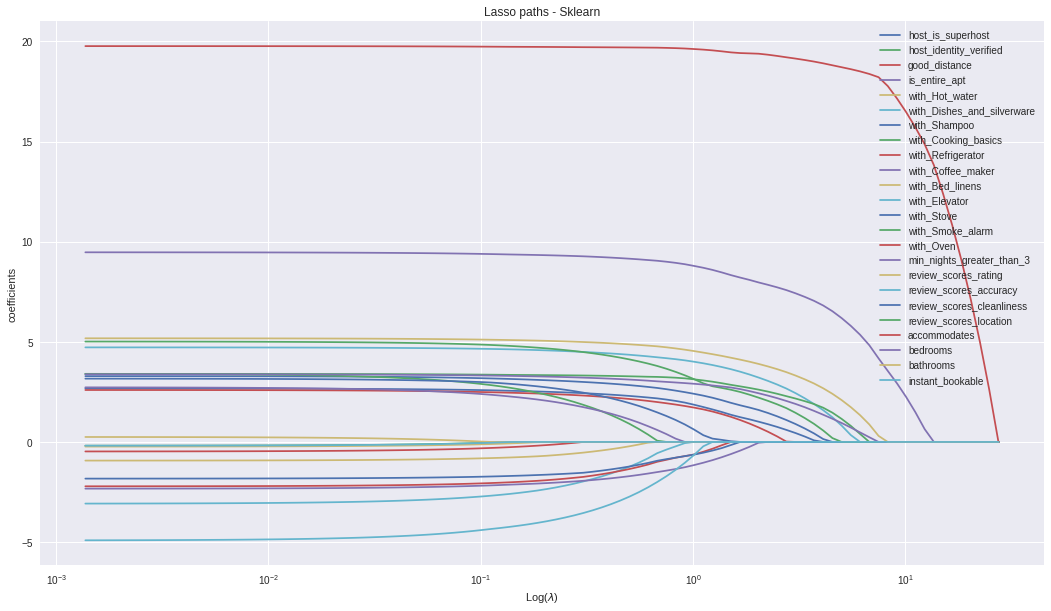

In [ ]:
# Display results
plt.figure(figsize = (18,10))

for i in range(X.shape[1]):
    plt.plot(alphas_lasso, coefs_lasso[i], label = selected[i])

plt.xscale('log')
plt.xlabel('Log($\\lambda$)')
plt.ylabel('coefficients')
plt.title('Lasso paths - Sklearn')
plt.legend()
plt.axis('tight')

We can remove then: instant_bookable, review_scores_checkin, review_scores_location

In [ ]:
selected2 = selected.copy()
selected2

['host_is_superhost',
 'host_identity_verified',
 'good_distance',
 'is_entire_apt',
 'with_Hot_water',
 'with_Dishes_and_silverware',
 'with_Shampoo',
 'with_Cooking_basics',
 'with_Refrigerator',
 'with_Coffee_maker',
 'with_Bed_linens',
 'with_Elevator',
 'with_Stove',
 'with_Smoke_alarm',
 'with_Oven',
 'min_nights_greater_than_3',
 'review_scores_rating',
 'review_scores_accuracy',
 'review_scores_cleanliness',
 'review_scores_location',
 'accommodates',
 'bedrooms',
 'bathrooms',
 'instant_bookable']

This is very long list - lets split it into 2 smaller lists:

In [ ]:
selected2_1 = selected2[:len(selected2)//2]
selected2_2 = selected2[len(selected2)//2:]
print(selected2_1)
print(selected2_2)

['host_is_superhost', 'host_identity_verified', 'good_distance', 'is_entire_apt', 'with_Hot_water', 'with_Dishes_and_silverware', 'with_Shampoo', 'with_Cooking_basics', 'with_Refrigerator', 'with_Coffee_maker', 'with_Bed_linens', 'with_Elevator']
['with_Stove', 'with_Smoke_alarm', 'with_Oven', 'min_nights_greater_than_3', 'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_location', 'accommodates', 'bedrooms', 'bathrooms', 'instant_bookable']


In [ ]:
#selected2.remove('review_scores_accuracy')

#selected2.remove('instant_bookable')
#selected2.remove('with_Oven')


In [ ]:
selected2_1.remove('with_Bed_linens')
selected2_1.remove('with_Refrigerator')
selected2_1.remove('with_Dishes_and_silverware')
selected2_1.remove('with_Hot_water')
selected2_1.remove('with_Cooking_basics')
selected2_1

['host_is_superhost',
 'host_identity_verified',
 'good_distance',
 'is_entire_apt',
 'with_Shampoo',
 'with_Coffee_maker',
 'with_Elevator']

try Lasso again

In [ ]:
X = data_subset.loc[:,selected2_1]
X = preprocessing.scale(X)
y = np.array(data_subset.price)

alphas_lasso, coefs_lasso, _ = lasso_path(X, y, eps = 5e-5)

(0.0005758684965171106,
 31.006754870534248,
 -0.8348281415719744,
 17.53139097301146)

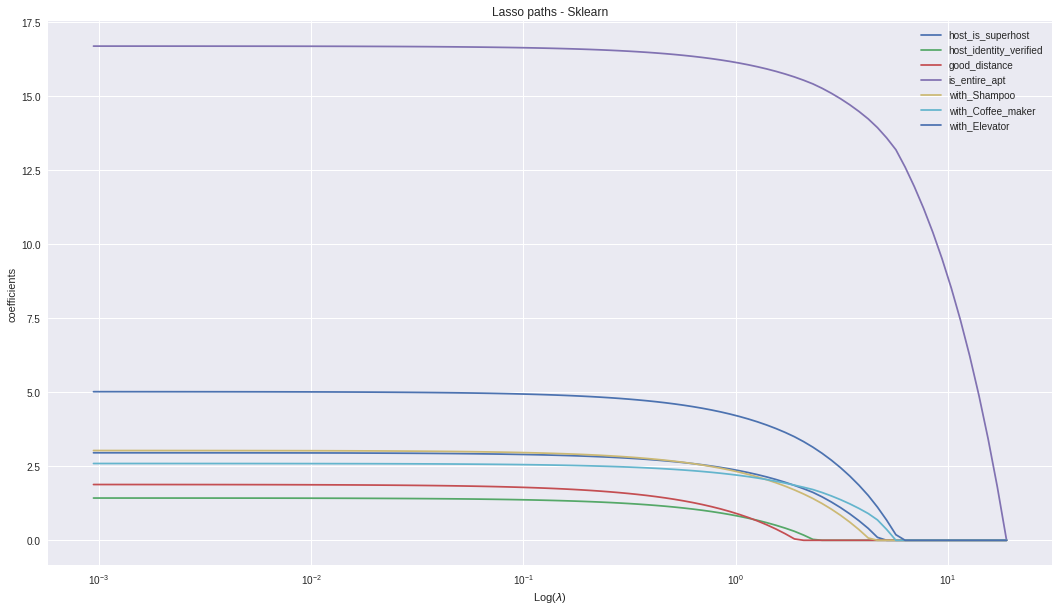

In [ ]:
# Display results
plt.figure(figsize = (18,10))

for i in range(X.shape[1]):
    plt.plot(alphas_lasso, coefs_lasso[i], label = selected2_1[i])

plt.xscale('log')
plt.xlabel('Log($\\lambda$)')
plt.ylabel('coefficients')
plt.title('Lasso paths - Sklearn')
plt.legend()
plt.axis('tight')

In [ ]:
selected2_2.remove('min_nights_greater_than_3')
selected2_2.remove('review_scores_accuracy')
selected2_2.remove('review_scores_rating')
selected2_2.remove('with_Stove')
selected2_2.remove('with_Oven')
selected2_2

['with_Smoke_alarm',
 'review_scores_cleanliness',
 'review_scores_location',
 'accommodates',
 'bedrooms',
 'bathrooms',
 'instant_bookable']

In [ ]:
X = data_subset.loc[:,selected2_2]
X = preprocessing.scale(X)
y = np.array(data_subset.price)

alphas_lasso, coefs_lasso, _ = lasso_path(X, y, eps = 5e-5)

(0.0008364191173707426,
 45.03570293946902,
 -1.21221784638389,
 25.456574774061686)

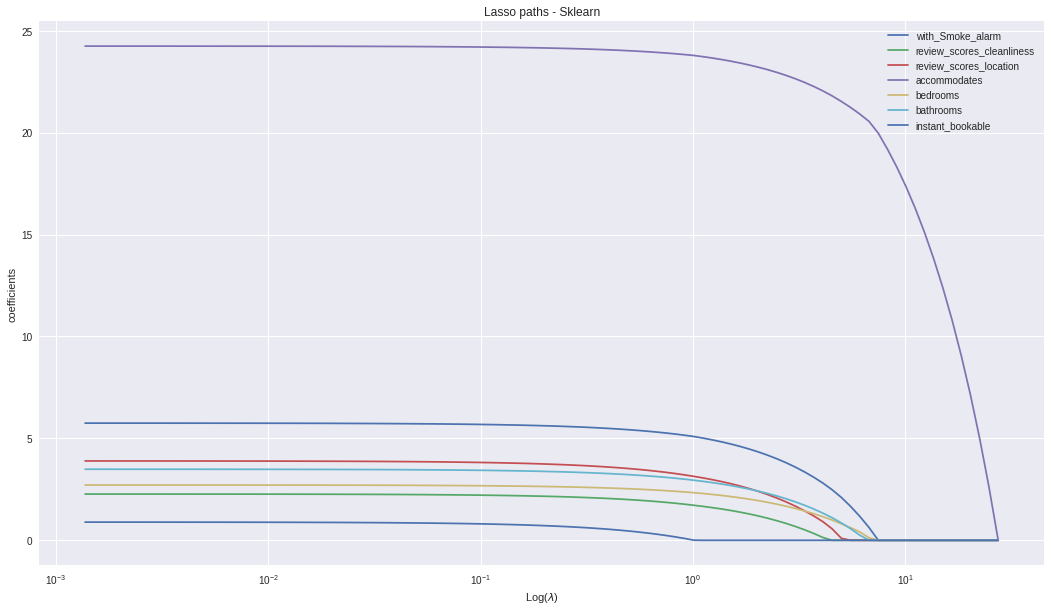

In [ ]:
# Display results
plt.figure(figsize = (18,10))

for i in range(X.shape[1]):
    plt.plot(alphas_lasso, coefs_lasso[i], label = selected2_2[i])

plt.xscale('log')
plt.xlabel('Log($\\lambda$)')
plt.ylabel('coefficients')
plt.title('Lasso paths - Sklearn')
plt.legend()
plt.axis('tight')

from those 2 halfs analysed above, we can now again take a look at selected as one:

In [ ]:
selected2 = selected2_1 + selected2_2
selected2

['host_is_superhost',
 'host_identity_verified',
 'good_distance',
 'is_entire_apt',
 'with_Shampoo',
 'with_Coffee_maker',
 'with_Elevator',
 'with_Smoke_alarm',
 'review_scores_cleanliness',
 'review_scores_location',
 'accommodates',
 'bedrooms',
 'bathrooms',
 'instant_bookable']

lets remove those attributes, which have negative influence for merged list

In [ ]:
selected2.remove('with_Coffee_maker')
selected2.remove('host_identity_verified')
selected2.remove('review_scores_cleanliness')
selected2.remove('instant_bookable')
selected2

['host_is_superhost',
 'good_distance',
 'is_entire_apt',
 'with_Shampoo',
 'with_Elevator',
 'with_Smoke_alarm',
 'review_scores_location',
 'accommodates',
 'bedrooms',
 'bathrooms']

In [ ]:
X = data_subset.loc[:,selected2]
X = preprocessing.scale(X)
y = np.array(data_subset.price)

alphas_lasso, coefs_lasso, _ = lasso_path(X, y, eps = 5e-5)

(0.0008364191173707426,
 45.03570293946902,
 -0.9957413767348021,
 20.910568911430843)

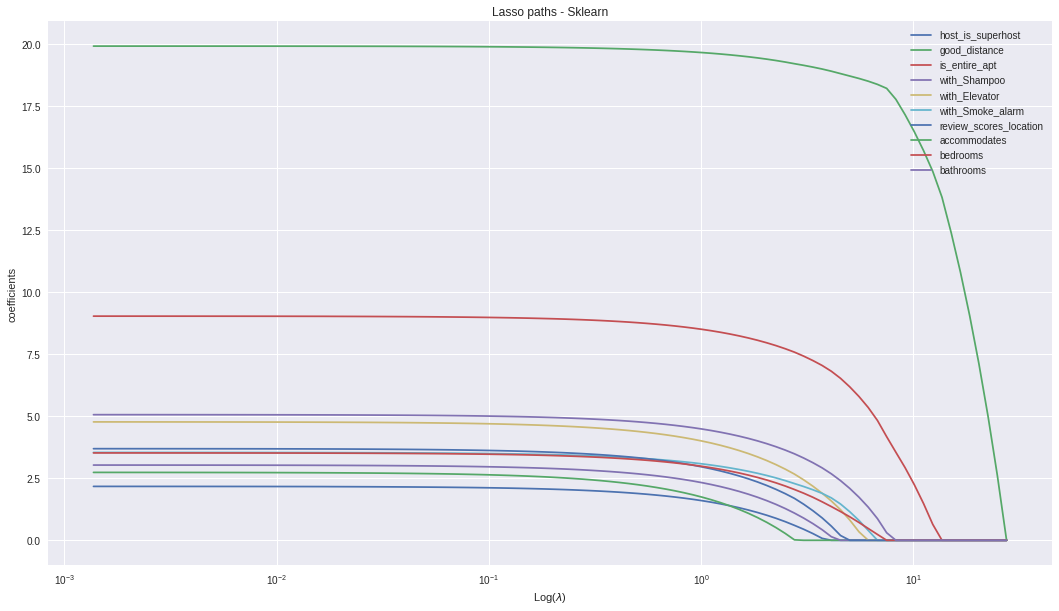

In [ ]:
# Display results
plt.figure(figsize = (18,10))

for i in range(X.shape[1]):
    plt.plot(alphas_lasso, coefs_lasso[i], label = selected2[i])

plt.xscale('log')
plt.xlabel('Log($\\lambda$)')
plt.ylabel('coefficients')
plt.title('Lasso paths - Sklearn')
plt.legend()
plt.axis('tight')

Now its much better. At the end lets remove accomodates value, sice it is srtrongly connected with bedrooms

In [ ]:
selected2_no_accomodates = selected2.copy()
selected2_no_accomodates.remove('accommodates')
selected2_no_accomodates

['host_is_superhost',
 'good_distance',
 'is_entire_apt',
 'with_Shampoo',
 'with_Elevator',
 'with_Smoke_alarm',
 'review_scores_location',
 'bedrooms',
 'bathrooms']

In [ ]:
# It will work better in the future, when it is rearanged:
selected2_no_accomodates = ['bedrooms', 'host_is_superhost', 'good_distance', 'is_entire_apt', 'with_Shampoo', 'with_Elevator', 'with_Smoke_alarm', 'review_scores_location']

#XGB Repeated

In [ ]:
from sklearn.preprocessing import StandardScaler
sc2 = StandardScaler()
scaledFeatures2 = sc2.fit_transform(data[selected2])
scaledFeatures2

array([[-0.60535414,  0.36154174, -1.7143002 , ..., -0.14588554,
        -0.38340718, -0.41242332],
       [ 1.6519256 ,  0.36154174,  0.58332841, ...,  0.97681392,
        -0.38340718, -0.41242332],
       [ 1.6519256 ,  0.36154174,  0.58332841, ...,  1.53816366,
         0.66225816, -0.41242332],
       ...,
       [-0.60535414,  0.36154174,  0.58332841, ...,  0.41546419,
        -0.38340718, -0.41242332],
       [-0.60535414,  0.36154174,  0.58332841, ..., -0.70723527,
        -0.38340718, -0.41242332],
       [-0.60535414,  0.36154174,  0.58332841, ...,  0.41546419,
         1.70792351,  0.70256692]])

In [ ]:
# Load packages and create test set
import xgboost as xgb
from xgboost import plot_importance
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error

X2 = scaledFeatures2
y = data["price"]
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y, test_size=0.2, random_state=42)

In [ ]:
#Initialize XGBoost classifier and find the best parameter sets with Grid Search CV
xgb_clf2 = xgb.XGBRegressor()
parameters = {'n_estimators': [80, 100, 120, 140], 'max_depth':[3,5,7,9]}
grid_search = GridSearchCV(estimator=xgb_clf, param_grid=parameters, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)
print(grid_search.best_params_)

[10:47:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
{'max_depth': 5, 'n_estimators': 80}


In [ ]:
# Xgb with best parameters
xgb_clf2 = xgb.XGBRegressor(n_estimators=100, max_depth=5)
xgb_clf2.fit(X_train2, y_train2)
y_test_pred2 = xgb_clf2.predict(X_test2)
print("R^2 score is: {0: .4f}".format(r2_score(y_test2, y_test_pred2)))
print("RMSE is: {0: .4f}".format(np.sqrt(mean_squared_error(y_test2, y_test_pred2))))

[10:47:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
R^2 score is:  0.4138
RMSE is:  39.4011


Last try - without accomodates

In [ ]:
from sklearn.preprocessing import StandardScaler
sc2_no_accomodates = StandardScaler()
scaledFeatures2_no_accomodates = sc.fit_transform(data[selected2_no_accomodates])
scaledFeatures2_no_accomodates

array([[-0.38340718, -0.60535414,  0.36154174, ..., -0.94536584,
         1.15773711, -0.05945888],
       [-0.38340718,  1.6519256 ,  0.36154174, ..., -0.94536584,
         1.15773711,  0.02079375],
       [ 0.66225816,  1.6519256 ,  0.36154174, ...,  1.05779155,
         1.15773711, -0.3804694 ],
       ...,
       [-0.38340718, -0.60535414,  0.36154174, ..., -0.94536584,
        -0.86375395,         nan],
       [-0.38340718, -0.60535414,  0.36154174, ..., -0.94536584,
         1.15773711,         nan],
       [ 1.70792351, -0.60535414,  0.36154174, ..., -0.94536584,
        -0.86375395,         nan]])

In [ ]:
# Load packages and create test set
import xgboost as xgb
from xgboost import plot_importance
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error

X2_no_accomodates = scaledFeatures2_no_accomodates
y = data["price"]
X_train2_no_accomodates, X_test2_no_accomodates, y_train2_no_accomodates, y_test2_no_accomodates = train_test_split(X2_no_accomodates, y, test_size=0.2, random_state=42)

In [ ]:
#Initialize XGBoost classifier and find the best parameter sets with Grid Search CV
xgb_clf2_no_accomodates = xgb.XGBRegressor()
parameters = {'n_estimators': [80, 100, 120, 140], 'max_depth':[3,5,7,9]}
grid_search = GridSearchCV(estimator=xgb_clf, param_grid=parameters, cv=5, n_jobs=-1)
grid_search.fit(X_train2_no_accomodates, y_train2_no_accomodates)
print(grid_search.best_params_)

[10:48:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
{'max_depth': 3, 'n_estimators': 100}


In [ ]:
# Xgb with best parameters
xgb_clf2_no_accomodates = xgb.XGBRegressor(n_estimators=100, max_depth=3)
xgb_clf2_no_accomodates.fit(X_train2_no_accomodates, y_train2_no_accomodates)
y_test_pred2_no_accomodates = xgb_clf2_no_accomodates.predict(X_test2_no_accomodates)
print("R^2 score is: {0: .4f}".format(r2_score(y_test2_no_accomodates, y_test_pred2_no_accomodates)))
print("RMSE is: {0: .4f}".format(np.sqrt(mean_squared_error(y_test2_no_accomodates, y_test_pred2_no_accomodates))))

[10:48:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
R^2 score is:  0.3944
RMSE is:  40.0499


We will use this set of data for further predictions

#Shapley

In [ ]:
explainer = shap.TreeExplainer(xgb_clf)
X = data[selected]
shap_values = explainer.shap_values(X)
X.iloc[0,:]

host_is_superhost             0.00
host_identity_verified        1.00
good_distance                 1.00
is_entire_apt                 0.00
with_Hot_water                1.00
with_Dishes_and_silverware    0.00
with_Shampoo                  1.00
with_Cooking_basics           0.00
with_Refrigerator             0.00
with_Coffee_maker             0.00
with_Bed_linens               1.00
with_Elevator                 0.00
with_Stove                    0.00
with_Smoke_alarm              1.00
with_Oven                     0.00
min_nights_greater_than_3     0.00
review_scores_rating          4.71
review_scores_accuracy        4.86
review_scores_cleanliness     4.93
review_scores_location        4.71
accommodates                  3.00
bedrooms                      1.00
bathrooms                     1.00
instant_bookable              0.00
Name: 0, dtype: float64

In [ ]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0,:], X.iloc[0,:])

In [ ]:
explainer2 = shap.TreeExplainer(xgb_clf2)
X2 = data[selected2]
shap_values2 = explainer2.shap_values(X2)
X2.iloc[0,:]

host_is_superhost         0.00
good_distance             1.00
is_entire_apt             0.00
with_Shampoo              1.00
with_Elevator             0.00
with_Smoke_alarm          1.00
review_scores_location    4.71
accommodates              3.00
bedrooms                  1.00
bathrooms                 1.00
Name: 0, dtype: float64

In [ ]:
shap.initjs()
shap.force_plot(explainer2.expected_value, shap_values2[0,:], X2.iloc[0,:])

In [ ]:
explainer2_no_accomodates = shap.TreeExplainer(xgb_clf2_no_accomodates)
X2_no_accomodates = data[selected2_no_accomodates]
shap_values2_no_accomodates = explainer2_no_accomodates.shap_values(X2_no_accomodates)
X2_no_accomodates.iloc[0,:]

bedrooms                  1.00
host_is_superhost         0.00
good_distance             1.00
is_entire_apt             0.00
with_Shampoo              1.00
with_Elevator             0.00
with_Smoke_alarm          1.00
review_scores_location    4.71
Name: 0, dtype: float64

In [ ]:
shap.initjs()
shap.force_plot(explainer2_no_accomodates.expected_value, shap_values2_no_accomodates[0,:], X2_no_accomodates.iloc[0,:])

#Linear Regression

In [ ]:
selected

['host_is_superhost',
 'host_identity_verified',
 'good_distance',
 'is_entire_apt',
 'with_Hot_water',
 'with_Dishes_and_silverware',
 'with_Shampoo',
 'with_Cooking_basics',
 'with_Refrigerator',
 'with_Coffee_maker',
 'with_Bed_linens',
 'with_Elevator',
 'with_Stove',
 'with_Smoke_alarm',
 'with_Oven',
 'min_nights_greater_than_3',
 'review_scores_rating',
 'review_scores_accuracy',
 'review_scores_cleanliness',
 'review_scores_location',
 'accommodates',
 'bedrooms',
 'bathrooms',
 'instant_bookable']

In [ ]:
selected2

['host_is_superhost',
 'good_distance',
 'is_entire_apt',
 'with_Shampoo',
 'with_Elevator',
 'with_Smoke_alarm',
 'review_scores_location',
 'accommodates',
 'bedrooms',
 'bathrooms']

In [ ]:
selected2_no_accomodates

['bedrooms',
 'host_is_superhost',
 'good_distance',
 'is_entire_apt',
 'with_Shampoo',
 'with_Elevator',
 'with_Smoke_alarm',
 'review_scores_location']

In [ ]:
import statsmodels.formula.api as smf

model = smf.ols('price ~ host_is_superhost + host_identity_verified + good_distance +is_entire_apt + with_Hot_water + with_Dishes_and_silverware + with_Shampoo + with_Cooking_basics + with_Refrigerator + with_Coffee_maker + with_Bed_linens + with_Elevator + with_Stove + with_Smoke_alarm + with_Oven + min_nights_greater_than_3 + review_scores_rating + review_scores_accuracy + review_scores_cleanliness + review_scores_location + accommodates + bedrooms + instant_bookable', data=data).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.378
Model:                            OLS   Adj. R-squared:                  0.377
Method:                 Least Squares   F-statistic:                     212.6
Date:                Sun, 05 Jun 2022   Prob (F-statistic):               0.00
Time:                        10:48:52   Log-Likelihood:                -41194.
No. Observations:                8057   AIC:                         8.244e+04
Df Residuals:                    8033   BIC:                         8.260e+04
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

In [ ]:
model2 = smf.ols('price ~ host_is_superhost + good_distance + is_entire_apt + with_Shampoo + with_Elevator + with_Smoke_alarm + review_scores_location + accommodates + bedrooms', data=data).fit()

print(model2.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.366
Model:                            OLS   Adj. R-squared:                  0.366
Method:                 Least Squares   F-statistic:                     517.0
Date:                Sun, 05 Jun 2022   Prob (F-statistic):               0.00
Time:                        10:48:52   Log-Likelihood:                -41271.
No. Observations:                8057   AIC:                         8.256e+04
Df Residuals:                    8047   BIC:                         8.263e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                -58

In [ ]:
model2_no_accomodates = smf.ols('price ~ host_is_superhost + good_distance + is_entire_apt + with_Shampoo + with_Elevator + with_Smoke_alarm + review_scores_location + bedrooms', data=data).fit()

print(model2_no_accomodates.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.260
Model:                            OLS   Adj. R-squared:                  0.259
Method:                 Least Squares   F-statistic:                     353.2
Date:                Sun, 05 Jun 2022   Prob (F-statistic):               0.00
Time:                        10:48:52   Log-Likelihood:                -41897.
No. Observations:                8057   AIC:                         8.381e+04
Df Residuals:                    8048   BIC:                         8.387e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                -38

W can see, that we can remoove Washer, due to low p

In [ ]:
model_final = smf.ols('price ~ host_is_superhost + good_distance + is_entire_apt + with_Shampoo + with_Elevator + with_Smoke_alarm + review_scores_location + bedrooms', data=data).fit()

print(model_final.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.260
Model:                            OLS   Adj. R-squared:                  0.259
Method:                 Least Squares   F-statistic:                     353.2
Date:                Sun, 05 Jun 2022   Prob (F-statistic):               0.00
Time:                        10:48:52   Log-Likelihood:                -41897.
No. Observations:                8057   AIC:                         8.381e+04
Df Residuals:                    8048   BIC:                         8.387e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                -38

#Ceteris paribus

Lets calculate number of bedrooms

In [ ]:
['good_distance', 'is_entire_apt', 'with_Hair_dryer', 'with_Shampoo', 'review_scores_cleanliness']
data_temp = pd.DataFrame({"bedrooms" : [x for x in range(30)]})
data_temp['host_is_superhost'] = 1
data_temp['good_distance'] = 1
data_temp['is_entire_apt'] = 1
data_temp['with_Shampoo'] = 1
data_temp['with_Elevator'] = 1
data_temp['with_Smoke_alarm'] = 1
data_temp['review_scores_location'] = 4.8

data_temp

data_temp.head()

bedrooms  host_is_superhost  good_distance  is_entire_apt  with_Shampoo  \
0         0                  1              1              1             1   
1         1                  1              1              1             1   
2         2                  1              1              1             1   
3         3                  1              1              1             1   
4         4                  1              1              1             1   

   with_Elevator  with_Smoke_alarm  review_scores_location  
0              1                 1                     4.8  
1              1                 1                     4.8  
2              1                 1                     4.8  
3              1                 1                     4.8  
4              1                 1                     4.8

In [ ]:
# Code needed, to turn attribute names back anfter XGB modification
xgb_clf2_no_accomodates.get_booster().feature_names = ['bedrooms', 'host_is_superhost', 'good_distance', 'is_entire_apt', 'with_Shampoo', 'with_Elevator', 'with_Smoke_alarm', 'review_scores_location']
xgb_clf2_no_accomodates.get_booster().feature_names

['bedrooms',
 'host_is_superhost',
 'good_distance',
 'is_entire_apt',
 'with_Shampoo',
 'with_Elevator',
 'with_Smoke_alarm',
 'review_scores_location']

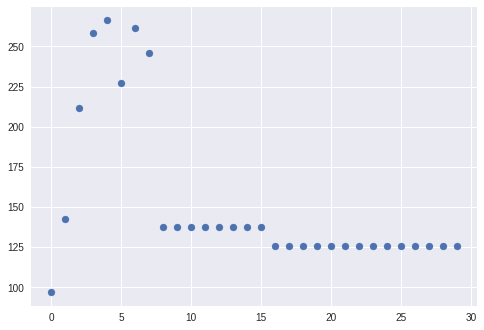

In [ ]:
data_subset = data.loc[:, selected2_no_accomodates + ['price']]
data_subset.dropna(inplace=True)
data_subset = data_subset.iloc[:1000,:]
data_temp = data_temp.reindex(columns=data_subset.columns)
data_temp.drop('price', axis=1, inplace=True)

#Predict
predictions_temp = xgb_clf2_no_accomodates.predict(data_temp)

#Plot
plt.scatter(x=data_temp.bedrooms, y=predictions_temp)
plt.show()

As usual - 2 and 3 bedrooms are quite good